<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/1IMRxByfg7gjoZ5i7rxvuNDvSrbdOJOc-/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
data = pd.read_excel("drive/MyDrive/data_problems.xlsx")
data = data.reset_index(drop=True)
task = list(data['Задача'])
label = list(data['Тема'])

In [ ]:
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from functools import partial

view = {'Геометрия': 0,
        'Графы': 1,
        'Дирихле': 2,
        'Инвариант': 3,
        'Комбинаторика': 4,
        'Многочлен': 5,
        'Теория чисел': 6}

def get_from_batch(list_tuple, tokenizer):
  tasks, labels = [], []
  for i in range(len(list_tuple)):
      tasks.append(list_tuple[i][0])
      labels.append(list_tuple[i][1])


  encoding = tokenizer(tasks, max_length=128, return_tensors='pt', truncation=True, padding='longest')

  labels_encoding = torch.Tensor(list(map(view.__getitem__, labels))).to(dtype=torch.long)

  encoding['labels'] = labels_encoding

  return encoding


task_label = list(zip(task, label))
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
loader = DataLoader(task_label, batch_size=64, collate_fn=partial(get_from_batch, tokenizer=tokenizer))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [ ]:
# ### This is just an interface example. You may change it if you want.

# class TransformerClassificationModel(nn.Module):
#     def __init__(base_transformer_model: Union[str, nn.Module]):
#         self.backbone = #...
#         # YOUR CODE: create additional layers for classfication

#     def forward(inputs, ...):
#         # YOUR CODE: propagate inputs through the model. Return dict with logits

#         outputs = {<YOUR CODE>}
#         return # YOUR CODE


from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn as nn

class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model, num_classes):
        super(TransformerClassificationModel, self).__init__()
        self.backbone = AutoModel.from_pretrained(base_transformer_model)
        self.tokenizer = AutoTokenizer.from_pretrained(base_transformer_model)
        self.classifier = nn.Linear(self.backbone.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(pooled_output)
        return logits


### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [ ]:
# def freeze_backbone_function(model: TransformerClassificationModel):
#     pass


def freeze_backbone_function(model: TransformerClassificationModel):
    for param in model.backbone.parameters():
        param.requires_grad = False
    return model


### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [ ]:
# import copy

# def train_transformer(transformer_model, freeze_backbone=True)
#     model = copy.copy(transformer_model)
#     ### YOUR CODE IS HERE

#     return finetuned_model


import copy
import torch
import torch.nn as nn
import torch.optim as optim

def train_transformer(transformer_model, freeze_backbone=True, num_epochs=5, train_dataloader=None, optimizer_lr=1e-3):
    model = copy.deepcopy(transformer_model)

    if freeze_backbone:
        model = freeze_backbone_function(model)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=optimizer_lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0

        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct_predictions += (logits.argmax(1) == labels).sum().item()

        epoch_loss = total_loss / len(train_dataloader)
        accuracy = correct_predictions / len(train_dataloader.dataset)

        print(f'Epoch {epoch + 1}/{num_epochs} | Loss: {epoch_loss:.4f} | Accuracy: {accuracy:.4f}')

    return model


### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [ ]:
# rubert_tiny_transformer_model = #...
# rubert_tiny_finetuned_with_freezed_backbone = train_transformer(rubert_tiny_transformer_model, freeze_backbone=True)

# rubert_tiny_transformer_model = #...
# rubert_tiny_full_finetuned = train_transformer(rubert_tiny_transformer_model, freeze_backbone=False)

# Загрузка руберт трансформера rubert-tiny2 и дообучение с замороженным backbone
rubert_tiny_transformer_model_freezed = TransformerClassificationModel(base_transformer_model="cointegrated/rubert-tiny2", num_classes=len(view))
rubert_tiny_finetuned_with_freezed_backbone = train_transformer(rubert_tiny_transformer_model_freezed, freeze_backbone=True, train_dataloader=loader)

# Загрузка руберт трансформера rubert-tiny2 и дообучение с размороженным backbone
rubert_tiny_transformer_model_full = TransformerClassificationModel(base_transformer_model="cointegrated/rubert-tiny2", num_classes=len(view))
rubert_tiny_full_finetuned = train_transformer(rubert_tiny_transformer_model_full, freeze_backbone=False, train_dataloader=loader)


Epoch 1/5 | Loss: 2.3031 | Accuracy: 0.2141
Epoch 2/5 | Loss: 1.7717 | Accuracy: 0.3239
Epoch 3/5 | Loss: 1.6745 | Accuracy: 0.4034
Epoch 4/5 | Loss: 1.6014 | Accuracy: 0.4225
Epoch 5/5 | Loss: 1.5542 | Accuracy: 0.4278
Epoch 1/5 | Loss: 1.1749 | Accuracy: 0.7622
Epoch 2/5 | Loss: 1.6212 | Accuracy: 0.5928
Epoch 3/5 | Loss: 0.9160 | Accuracy: 0.6757
Epoch 4/5 | Loss: 1.5980 | Accuracy: 0.5722
Epoch 5/5 | Loss: 1.7003 | Accuracy: 0.5712


### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

In [ ]:
### YOUR CODE IS HERE (probably, similar on the previous step)

tokenizer2 = AutoTokenizer.from_pretrained("tbs17/MathBert")
loader2 = DataLoader(task_label, batch_size=64, collate_fn=partial(get_from_batch, tokenizer=tokenizer2))

# Обучение модели MathBert с замороженным backbone
mathbert_trans_model_freezed = TransformerClassificationModel(base_transformer_model="tbs17/MathBert", num_classes=len(view))
mathbert_finetuned_with_freezed_backbone = train_transformer(mathbert_trans_model_freezed, freeze_backbone=True, train_dataloader=loader2)

# Обучение модели MathBert с размороженным backbone
mathbert_trans_model_full = TransformerClassificationModel(base_transformer_model="tbs17/MathBert", num_classes=len(view))
mathbert_full_finetuned = train_transformer(mathbert_trans_model_full, freeze_backbone=False, train_dataloader=loader2)


Epoch 1/5 | Loss: 3.6268 | Accuracy: 0.4045
Epoch 2/5 | Loss: 3.7846 | Accuracy: 0.3550
Epoch 3/5 | Loss: 3.5055 | Accuracy: 0.3387
Epoch 4/5 | Loss: 3.5326 | Accuracy: 0.3497
Epoch 5/5 | Loss: 3.4405 | Accuracy: 0.3546
Epoch 1/5 | Loss: 2.8393 | Accuracy: 0.6533
Epoch 2/5 | Loss: 2.1164 | Accuracy: 0.5961
Epoch 3/5 | Loss: 5.2255 | Accuracy: 0.4409
Epoch 4/5 | Loss: 2.2890 | Accuracy: 0.5115
Epoch 5/5 | Loss: 2.5425 | Accuracy: 0.5306


При кол-ве эпох = 5   
rubert с замороженным backbone хорошо дообучается, т.к. модель обучалась на руском языке  
rubert с незамороженным backbone скорее всего терял в Accuaracy из-за небольших размеров и переобучения на новых данных всей модели
mathbert изначально модель для математических формул, и при замороженном backbone ей приходится переобучаться только в голове из-за чего падает
Accuaracy
mathbert с незамороженным backbone за счёт своих размеров успевает переобучиться и начать улучшать показатели

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [ ]:
# def draw_first_layer_attention_maps(attention_head_ids: List, text: str, model: TransformerClassificationModel):
#     pass


import torch
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

def draw_first_layer_attention_maps(text, model):
    input_ids = model.tokenizer(text, return_tensors='pt', max_length=512, truncation=True)
    del input_ids['token_type_ids']
    model = model.to('cuda')
    attention_head_ids = [0]  # Пример выбора голов внимания

    input_ids = input_ids.to('cuda')
    with torch.no_grad():
        outputs = model.backbone(**input_ids, output_attentions=True)

    for head_id in attention_head_ids:
        attention_map = outputs['attentions'][0][0][head_id].cpu().numpy()

        # Отрисовка карты внимания
        plt.figure(figsize=(8, 8))
        plt.imshow(attention_map, cmap='hot', interpolation='nearest')
        plt.title(f'Attention Map for Head {head_id} - {text}')
        plt.xlabel('Input Tokens')
        plt.ylabel('Output Tokens')
        plt.show()



### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

Model: rubert_tiny_freezed


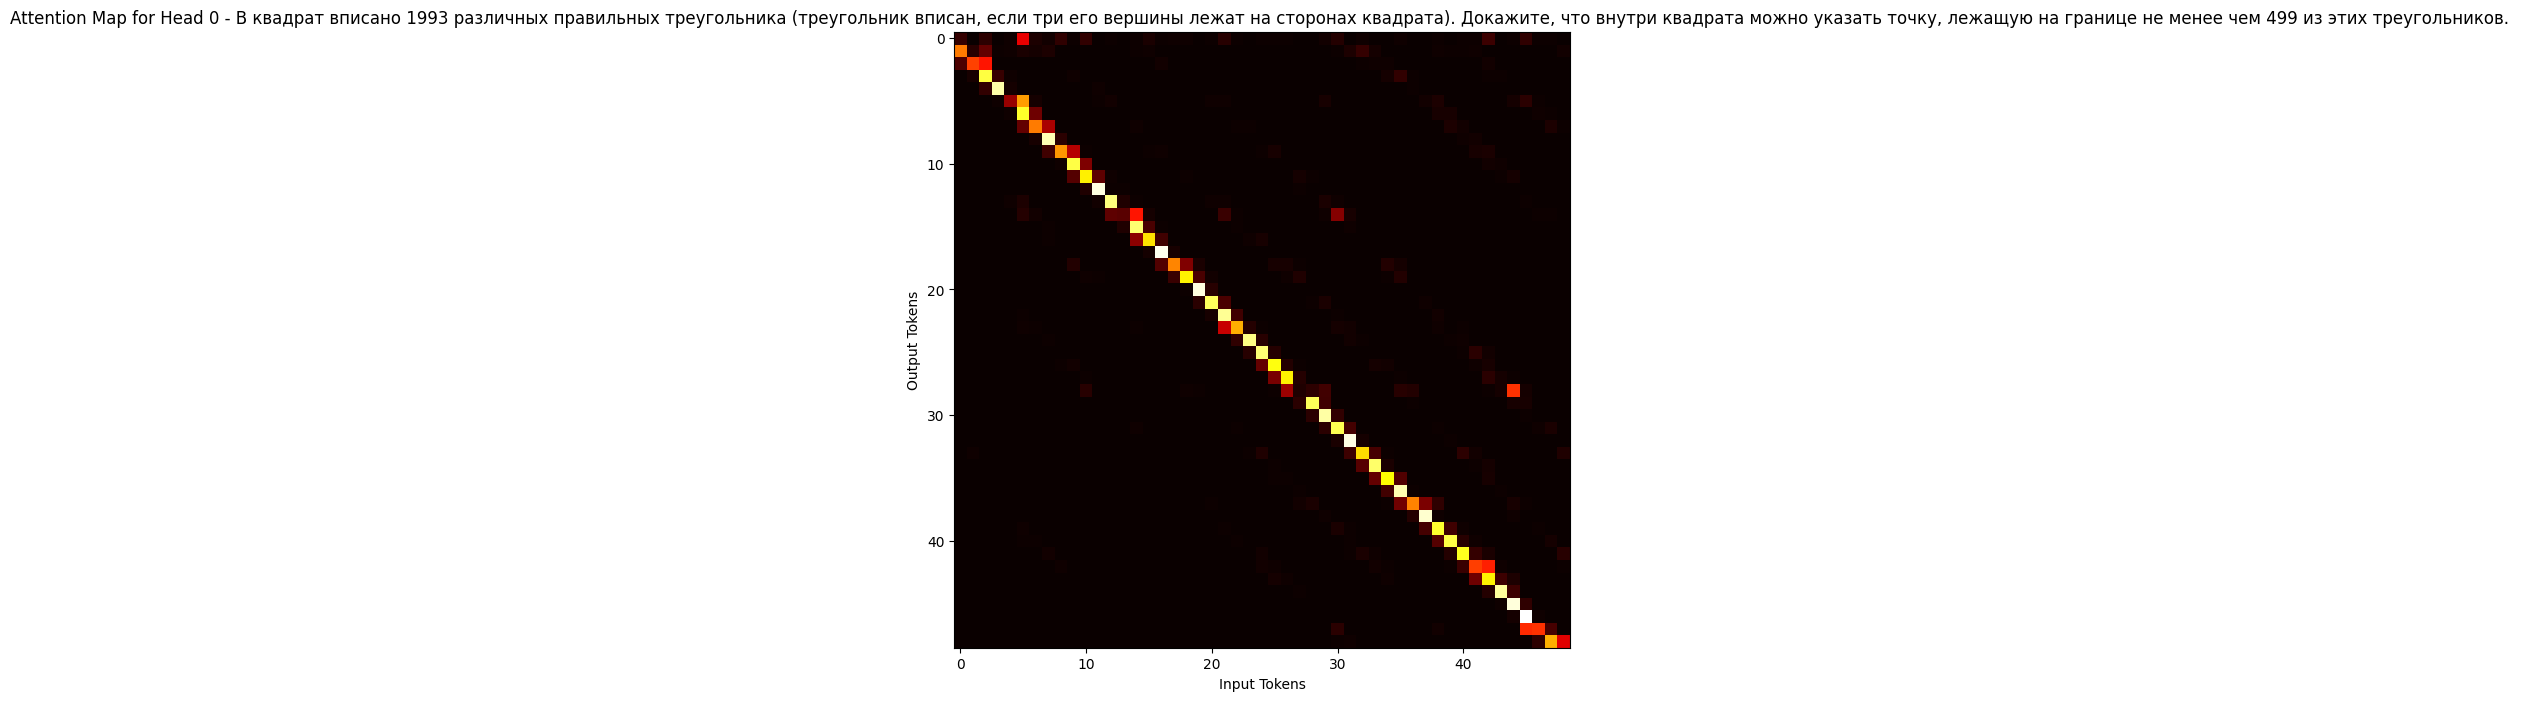

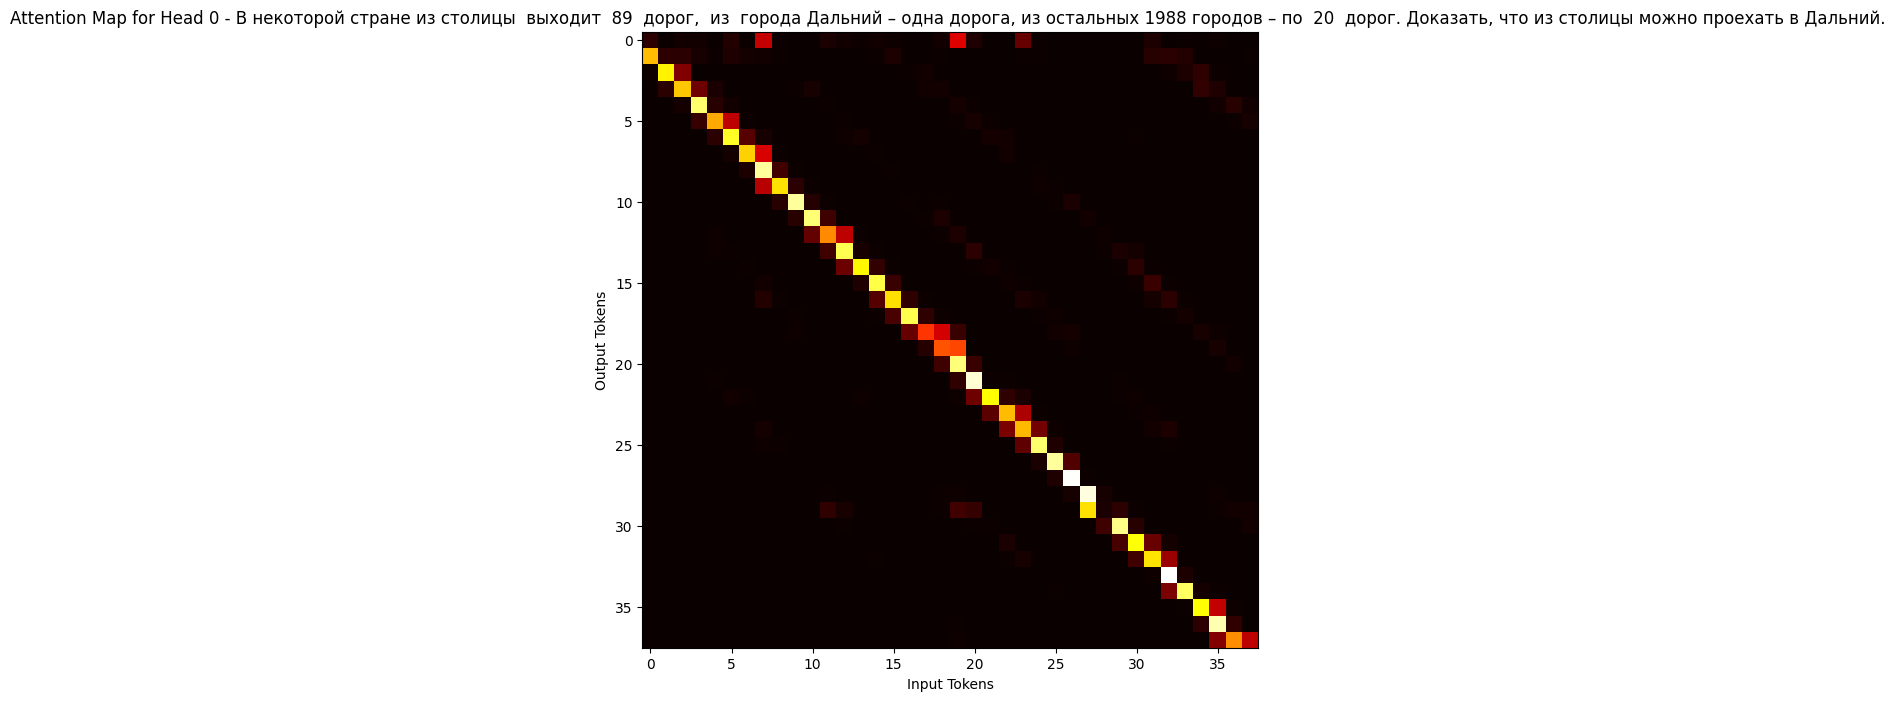

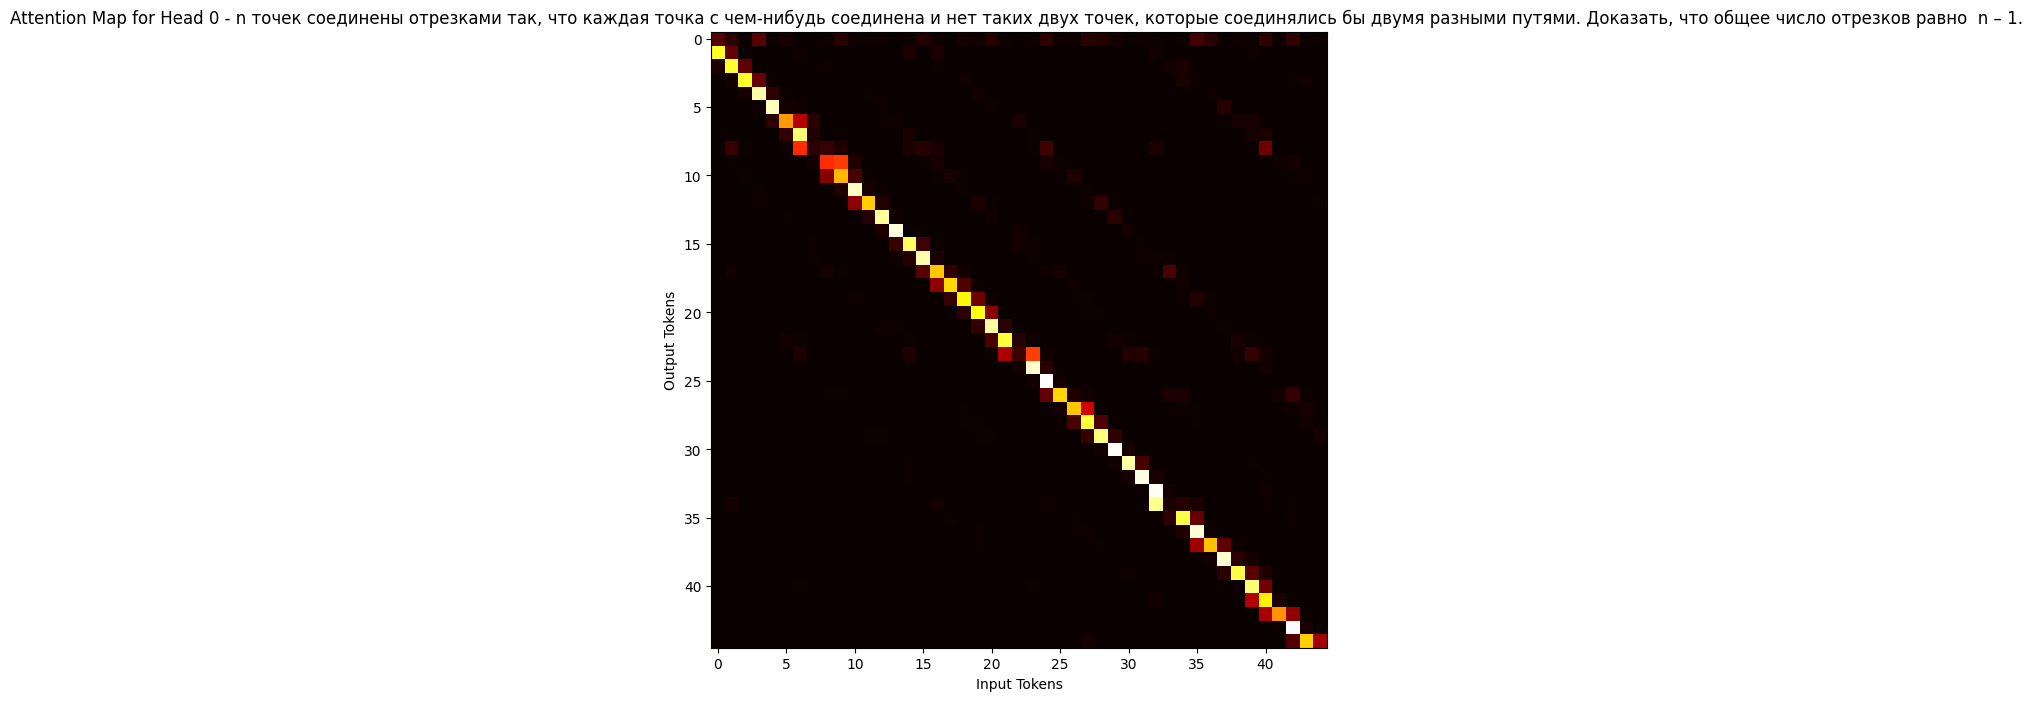

Model: rubert_tiny_full


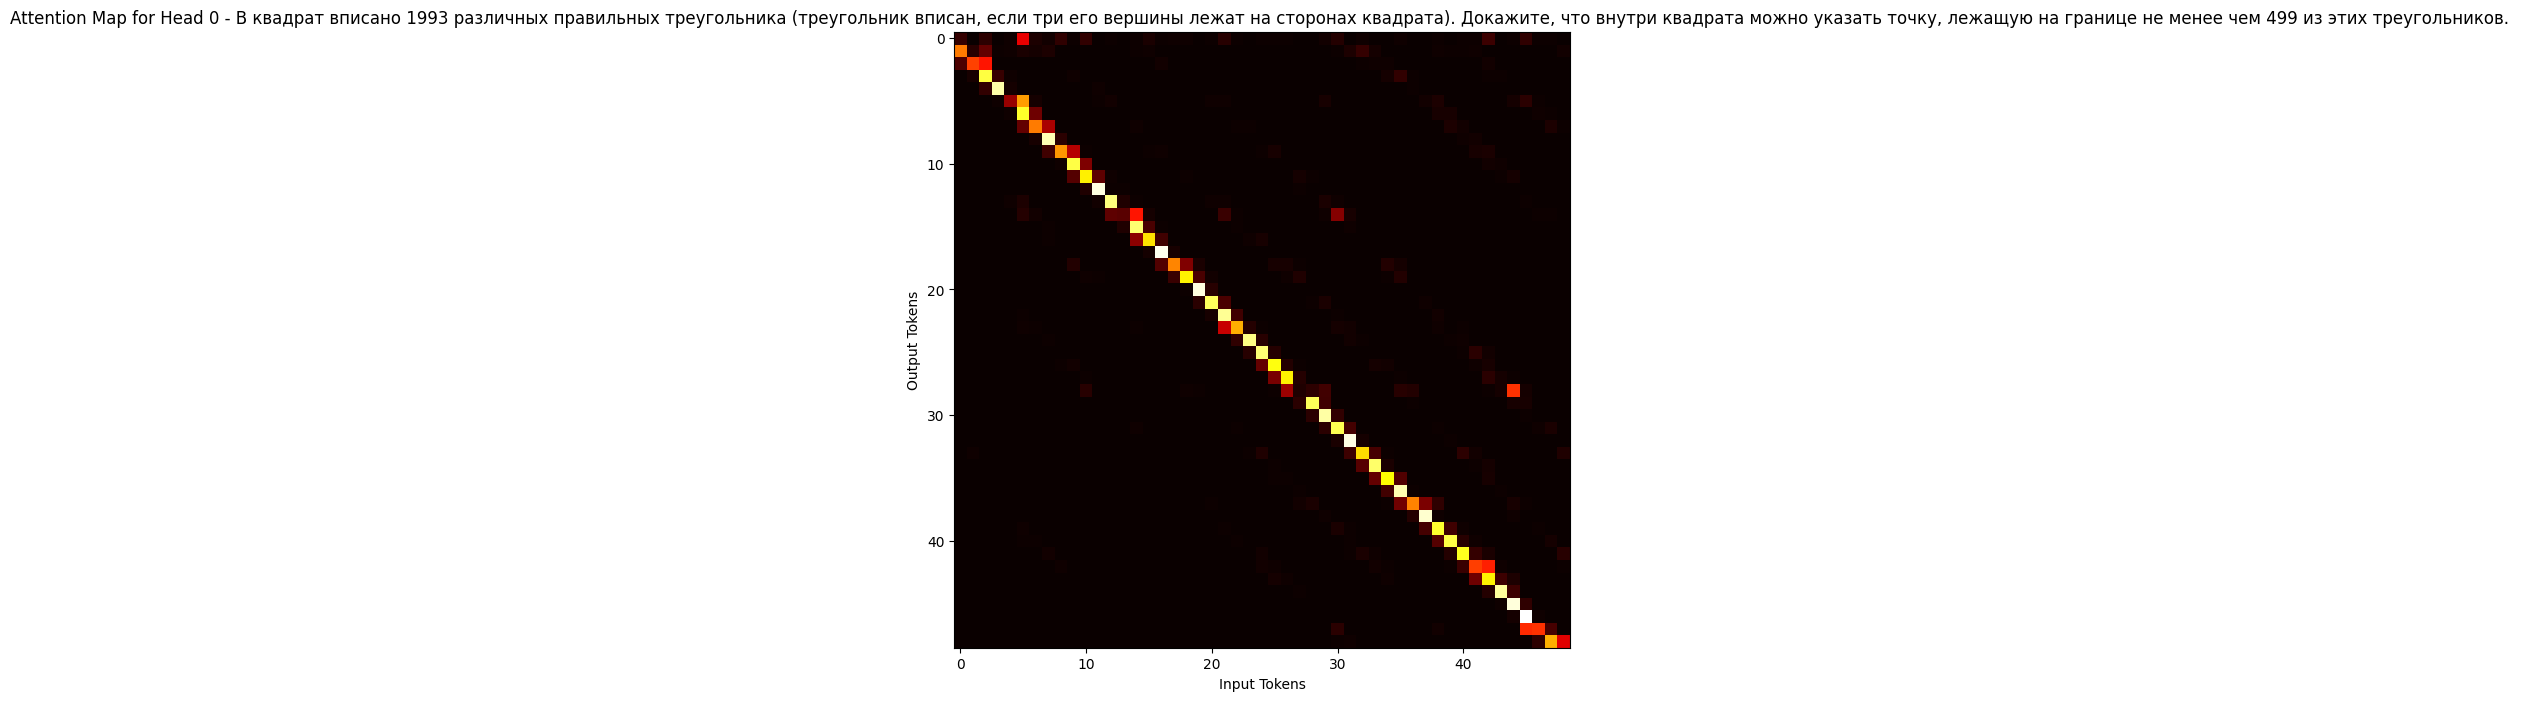

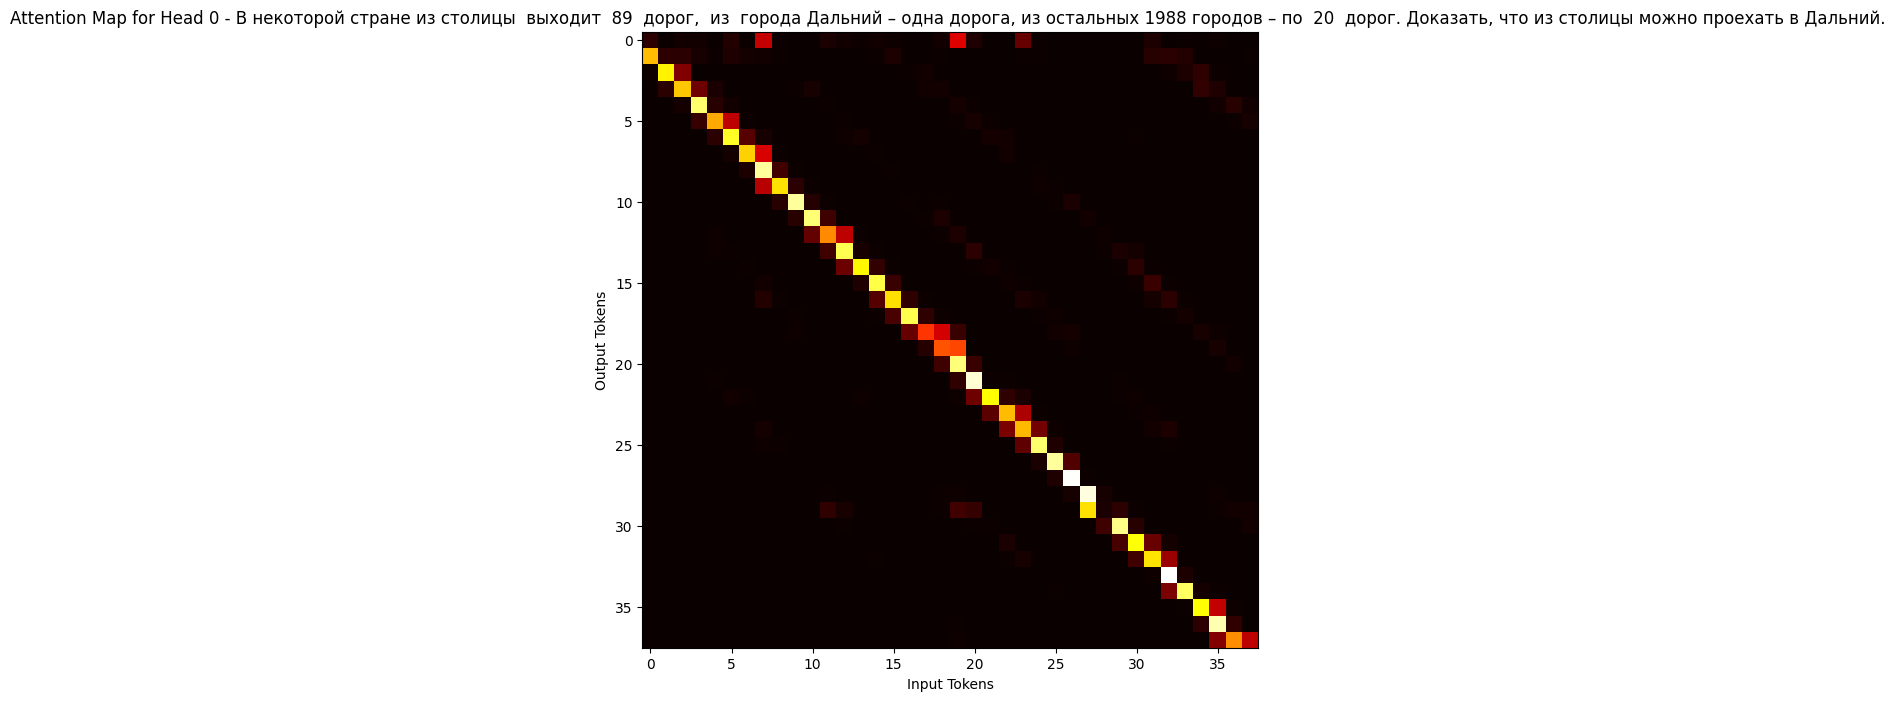

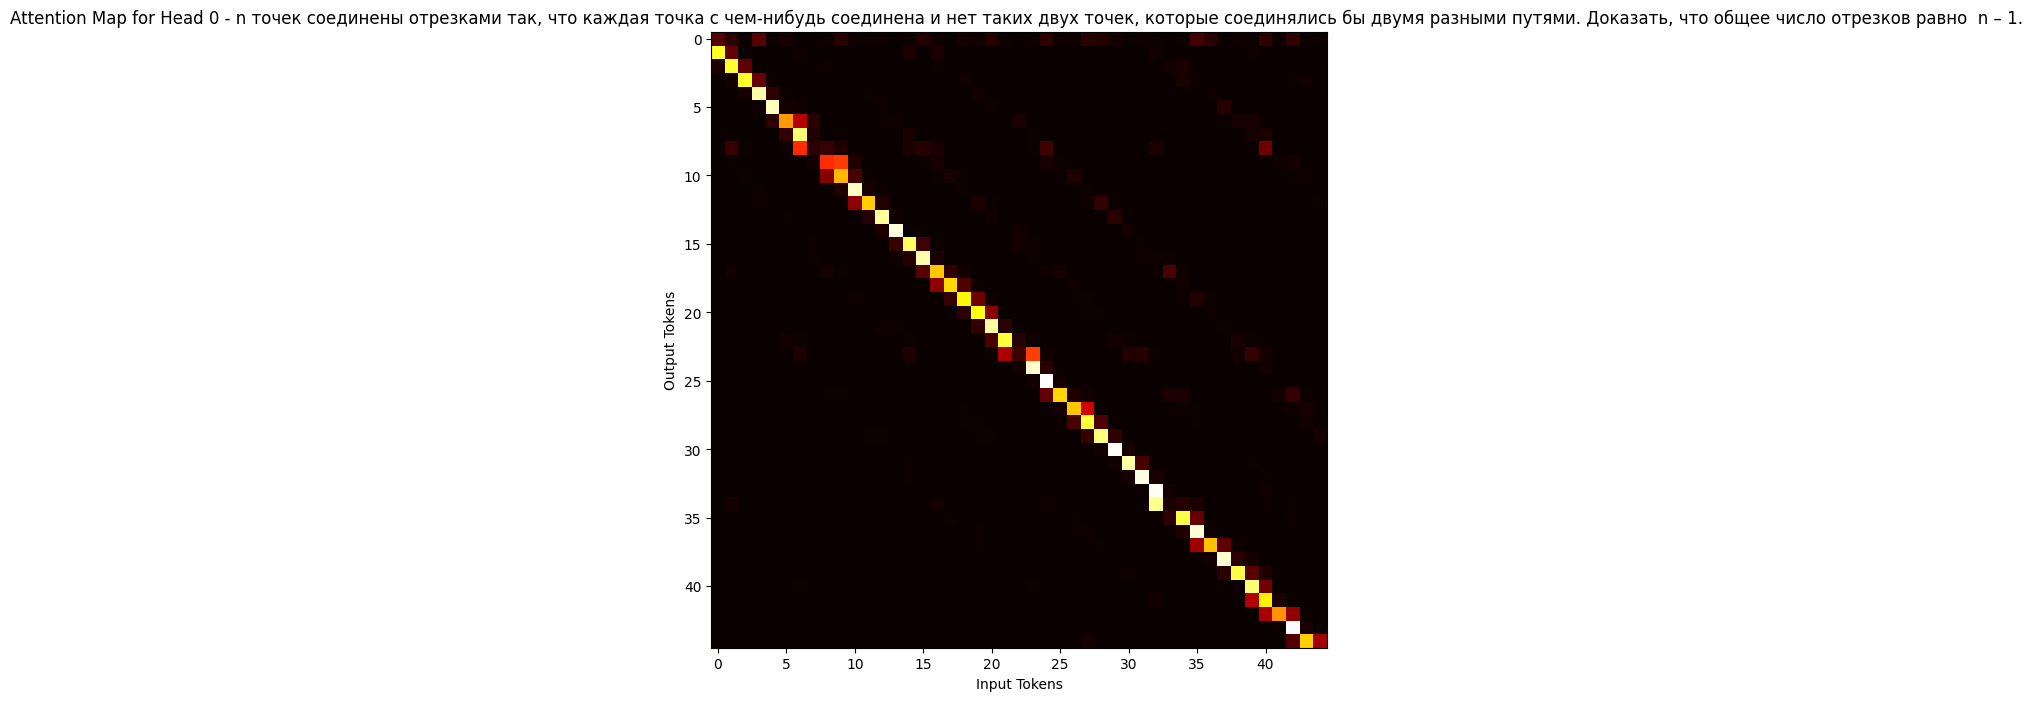

Model: mathbert_freezed


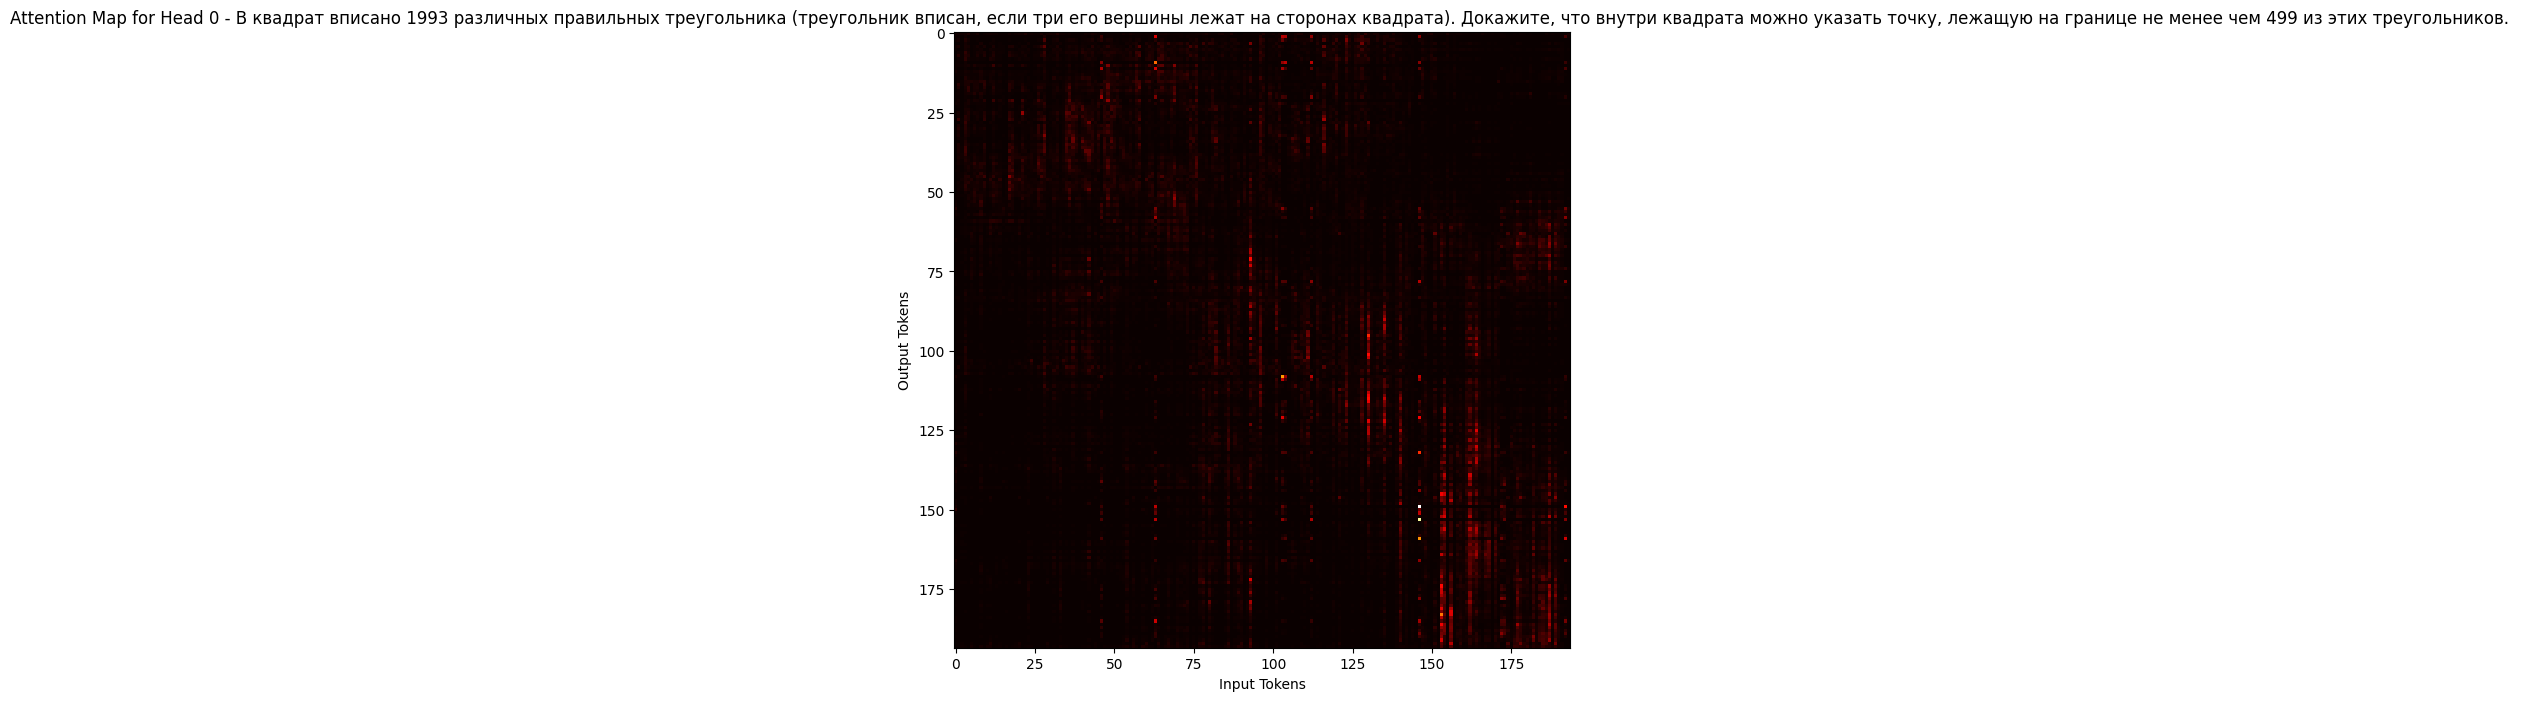

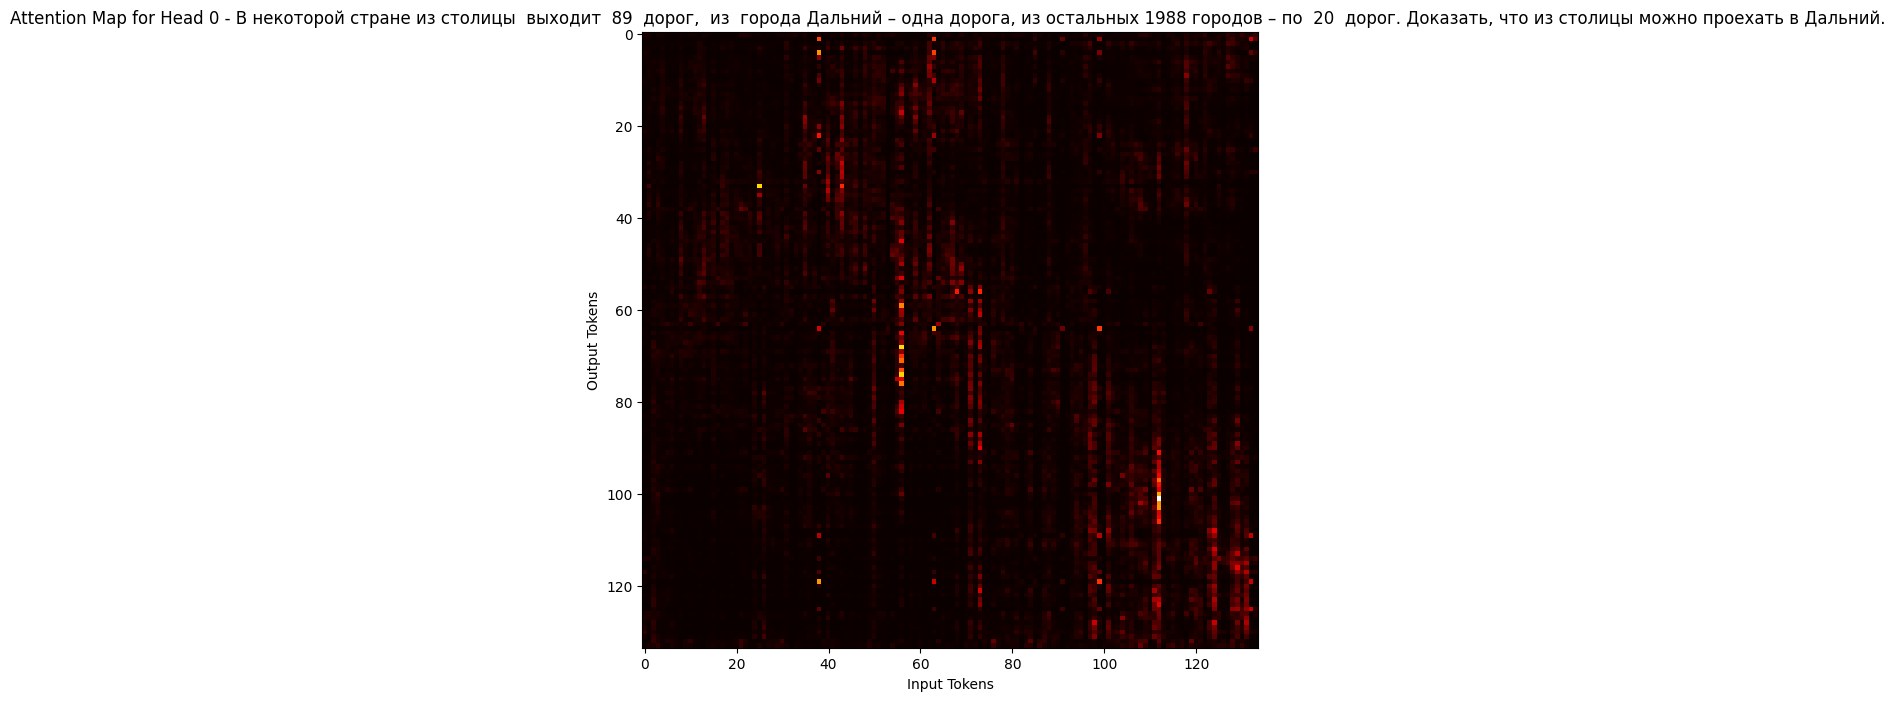

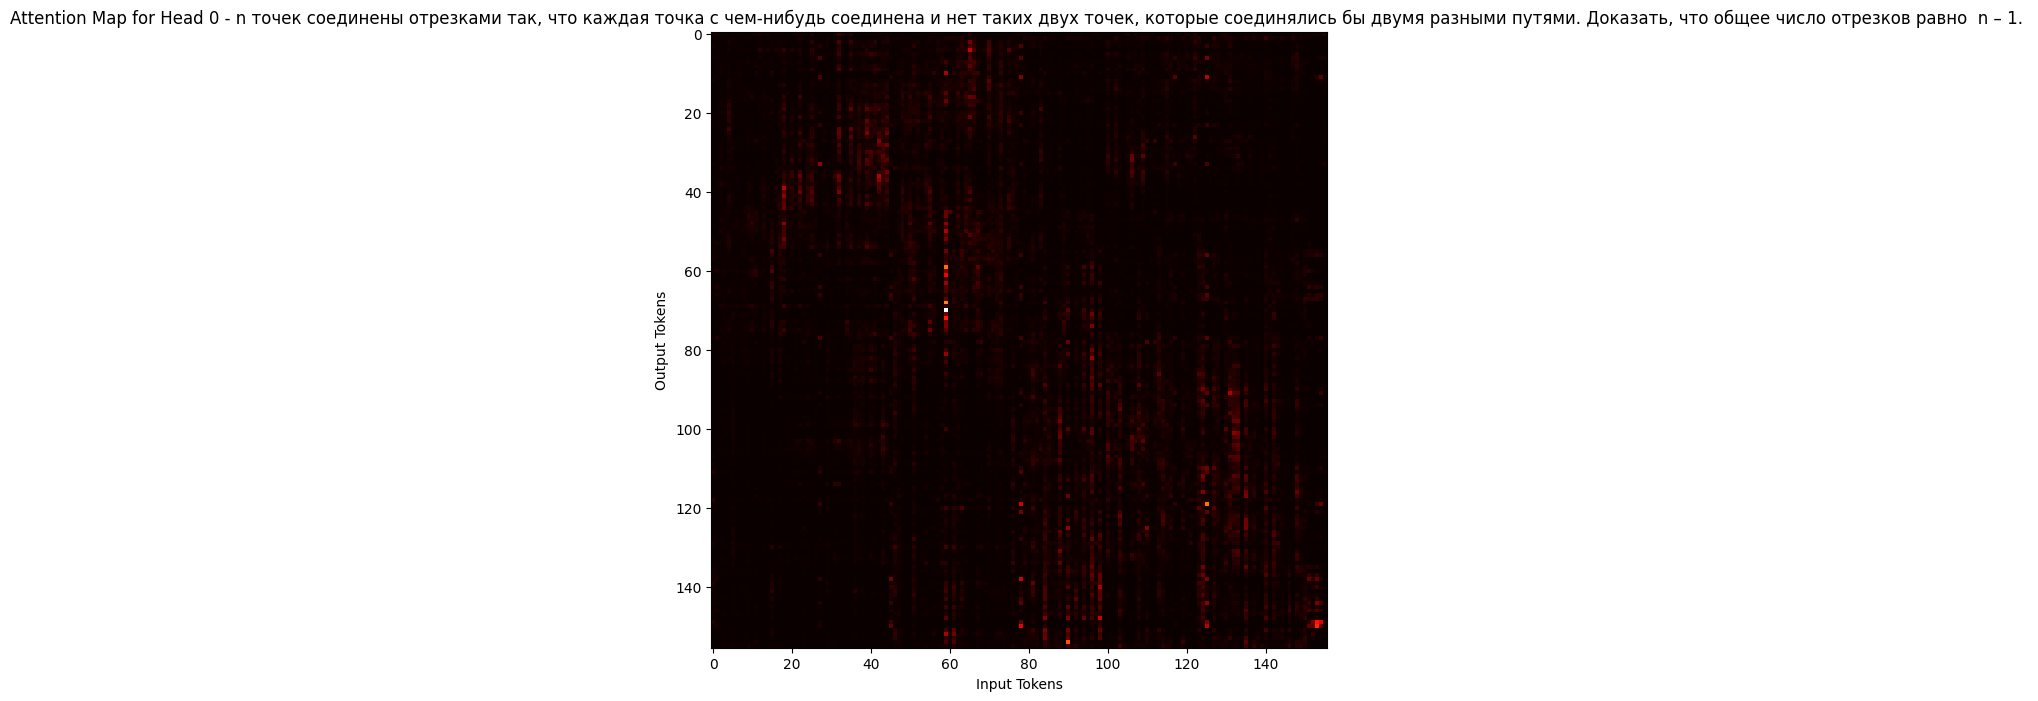

Model: mathbert_full


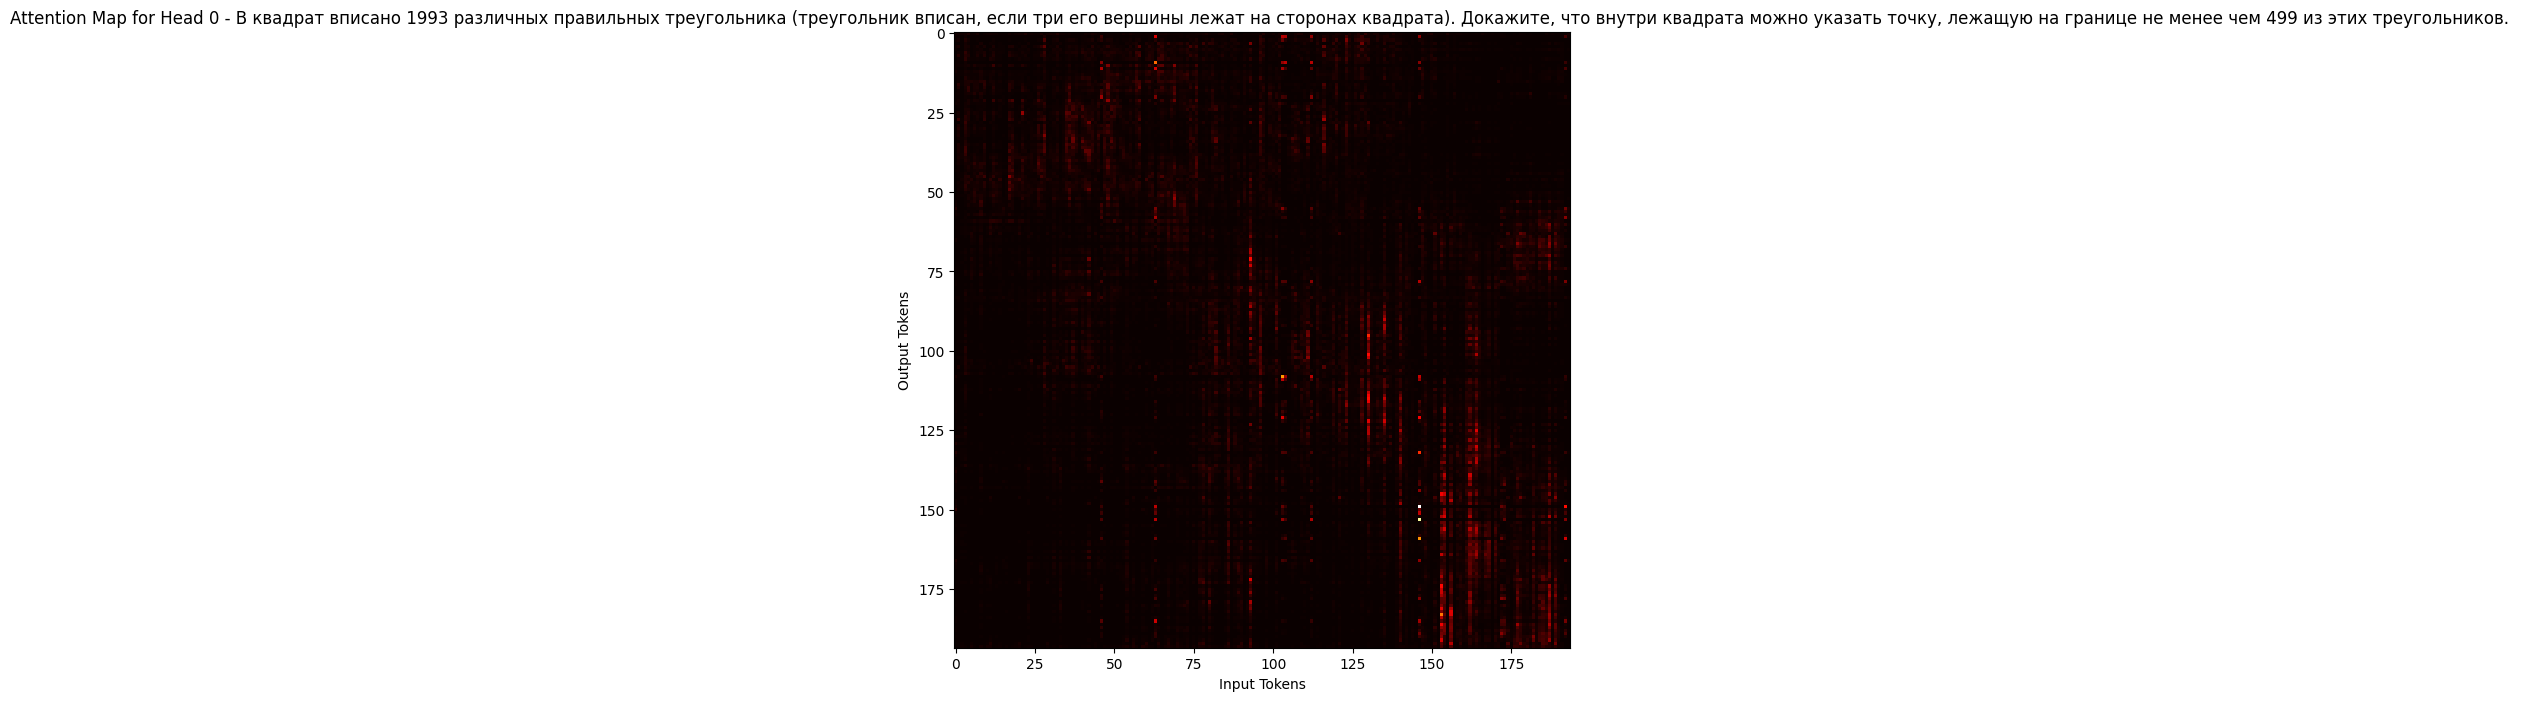

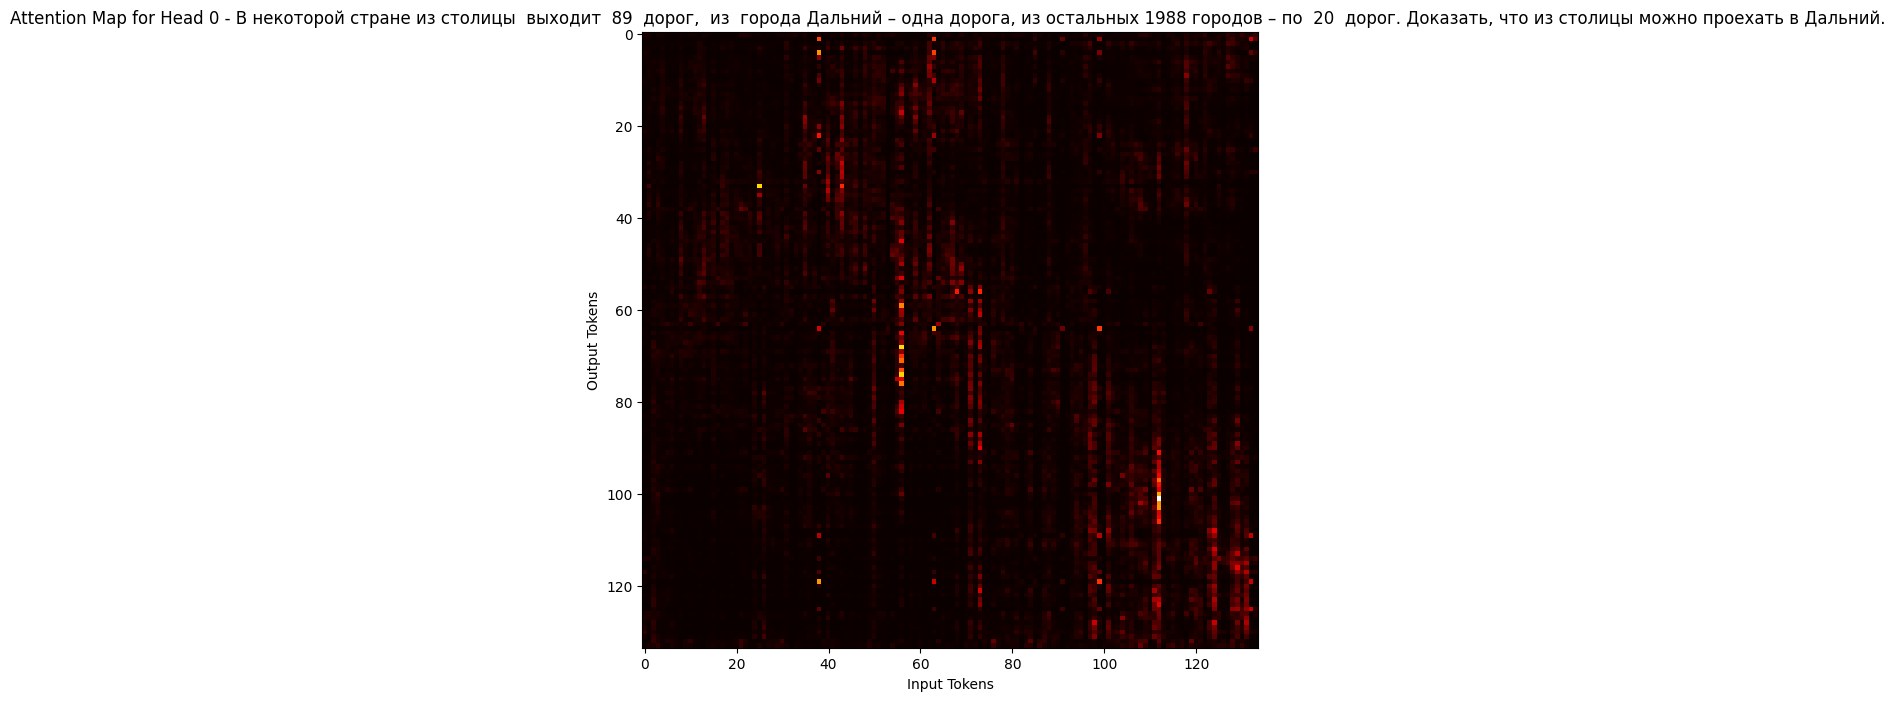

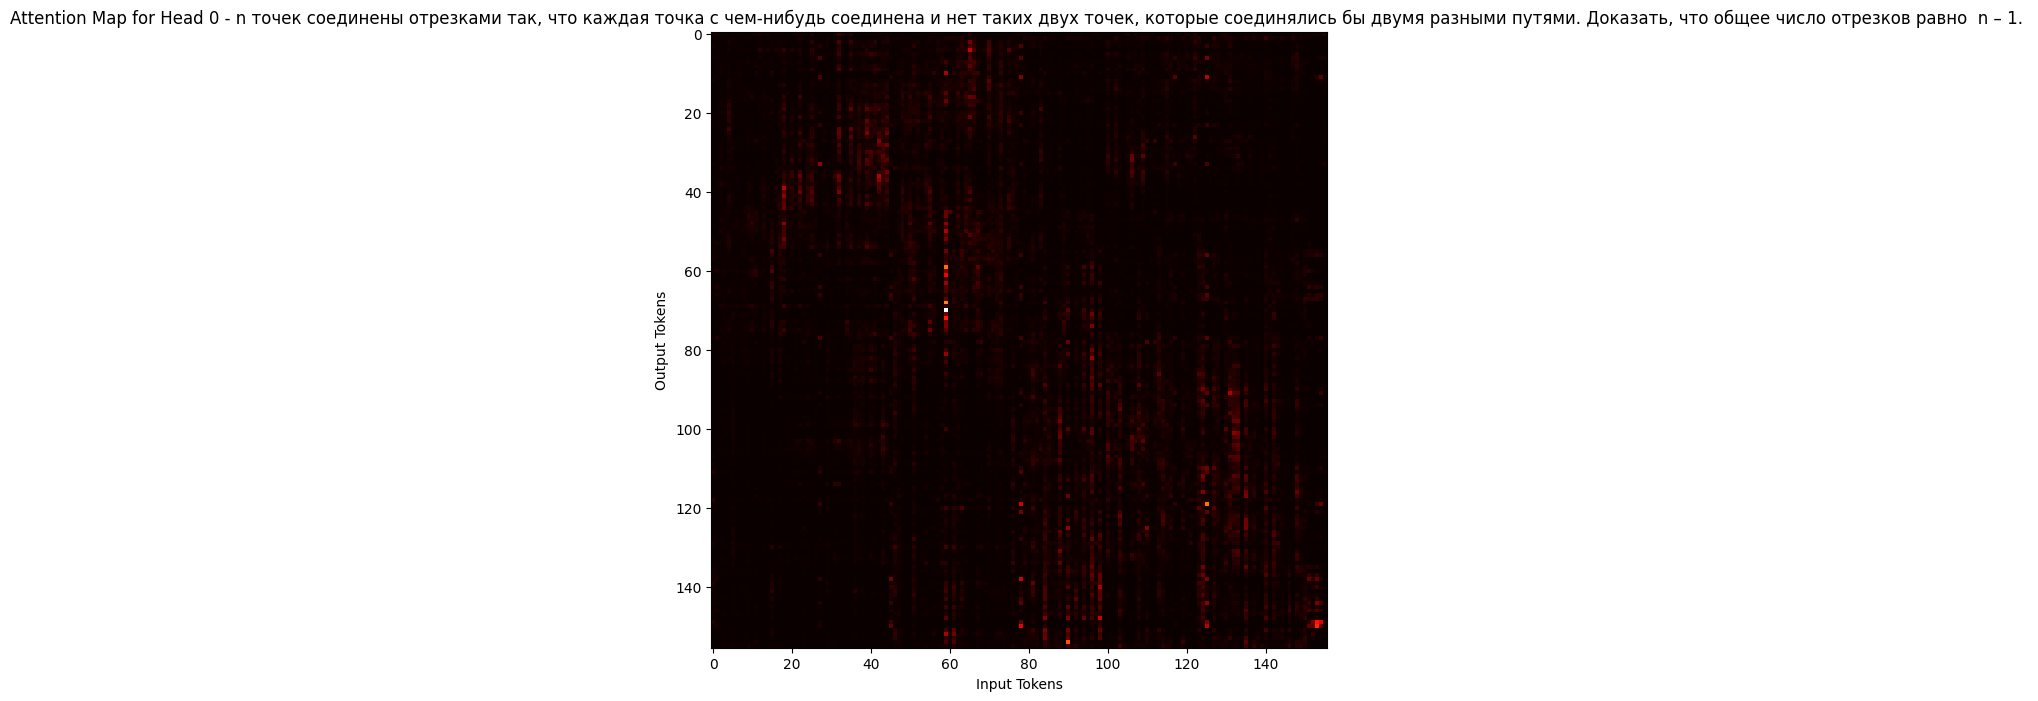

In [ ]:
### YOUR CODE IS HERE

### Пример использования для всех моделей до дообучения на выбранных текстах и анализе карт внимания

text_examples = ["В квадрат вписано 1993 различных правильных треугольника (треугольник вписан, если три его вершины лежат на сторонах квадрата). Докажите, что внутри квадрата можно указать точку, лежащую на границе не менее чем 499 из этих треугольников. ",
                "В некоторой стране из столицы  выходит  89  дорог,  из  города Дальний – одна дорога, из остальных 1988 городов – по  20  дорог. Доказать, что из столицы можно проехать в Дальний. ",
                "n точек соединены отрезками так, что каждая точка с чем-нибудь соединена и нет таких двух точек, которые соединялись бы двумя разными путями. Доказать, что общее число отрезков равно  n – 1. "]

# Пример инференса и анализа карт внимания
for model_name, model in {
    'rubert_tiny_freezed': rubert_tiny_transformer_model_freezed,
    'rubert_tiny_full': rubert_tiny_transformer_model_full,
    'mathbert_freezed': mathbert_trans_model_freezed,
    'mathbert_full': mathbert_trans_model_full
}.items():
    print(f"Model: {model_name}")

    for text in text_examples:
        draw_first_layer_attention_maps(text, model)


Яркие области указывают на высокую степень взаимного внимания между токенами, тогда как тёмные области указывают на более слабое внимание или отсутствие взаимного внимания.


### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

Model: rubert_tiny_freezed


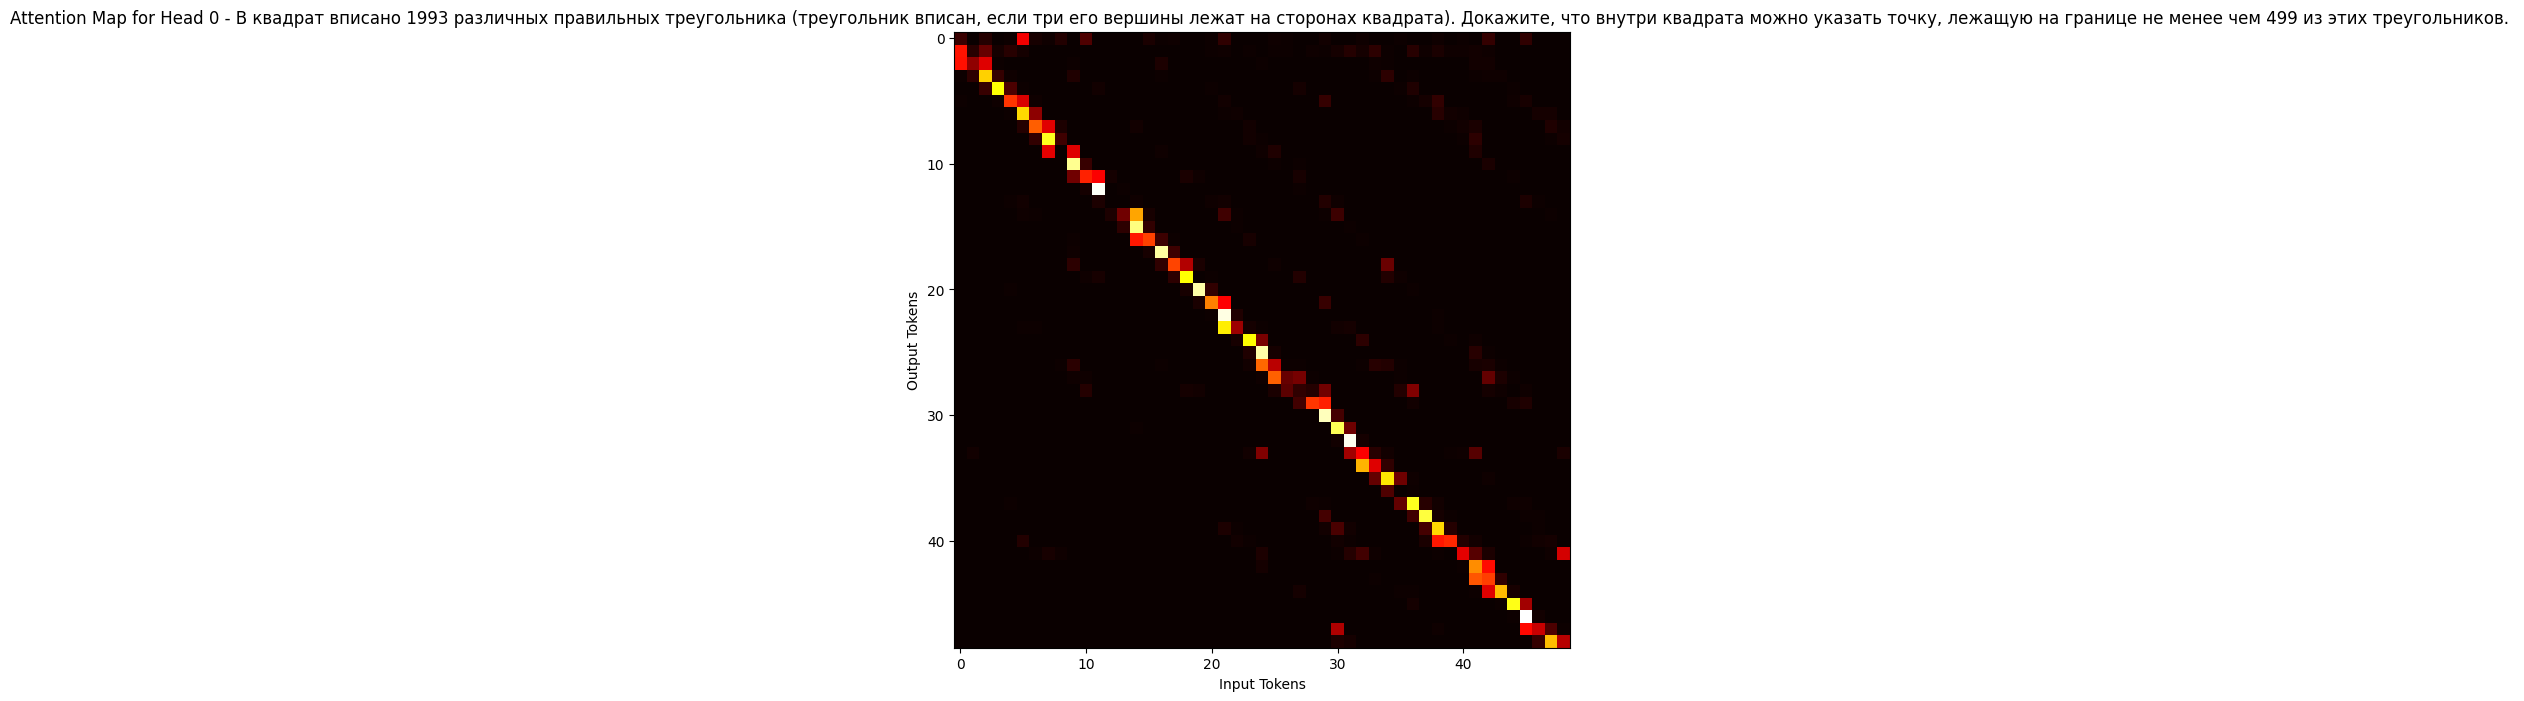

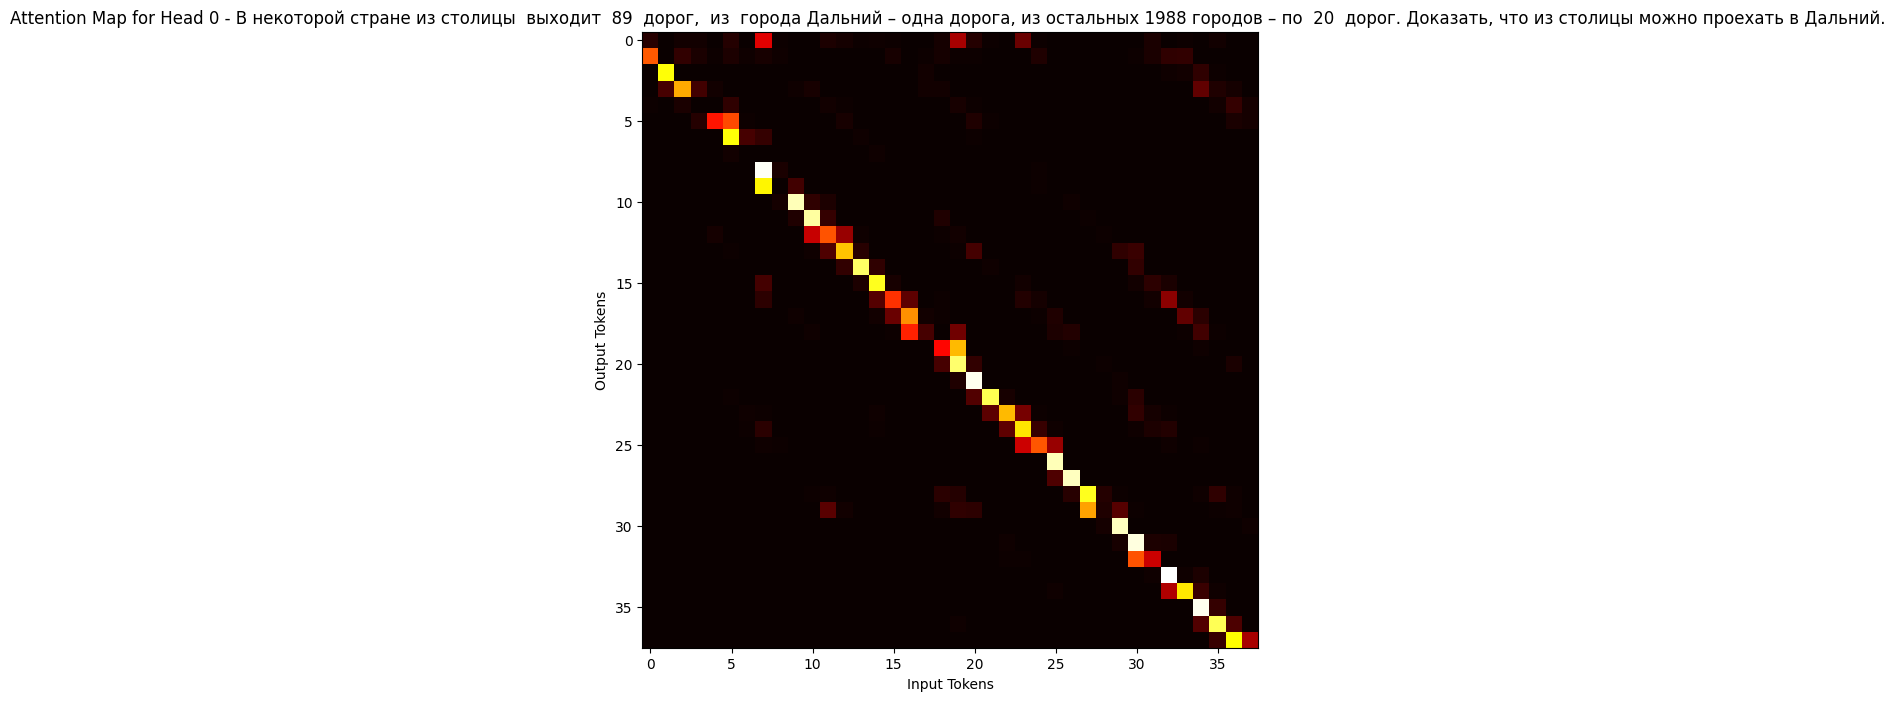

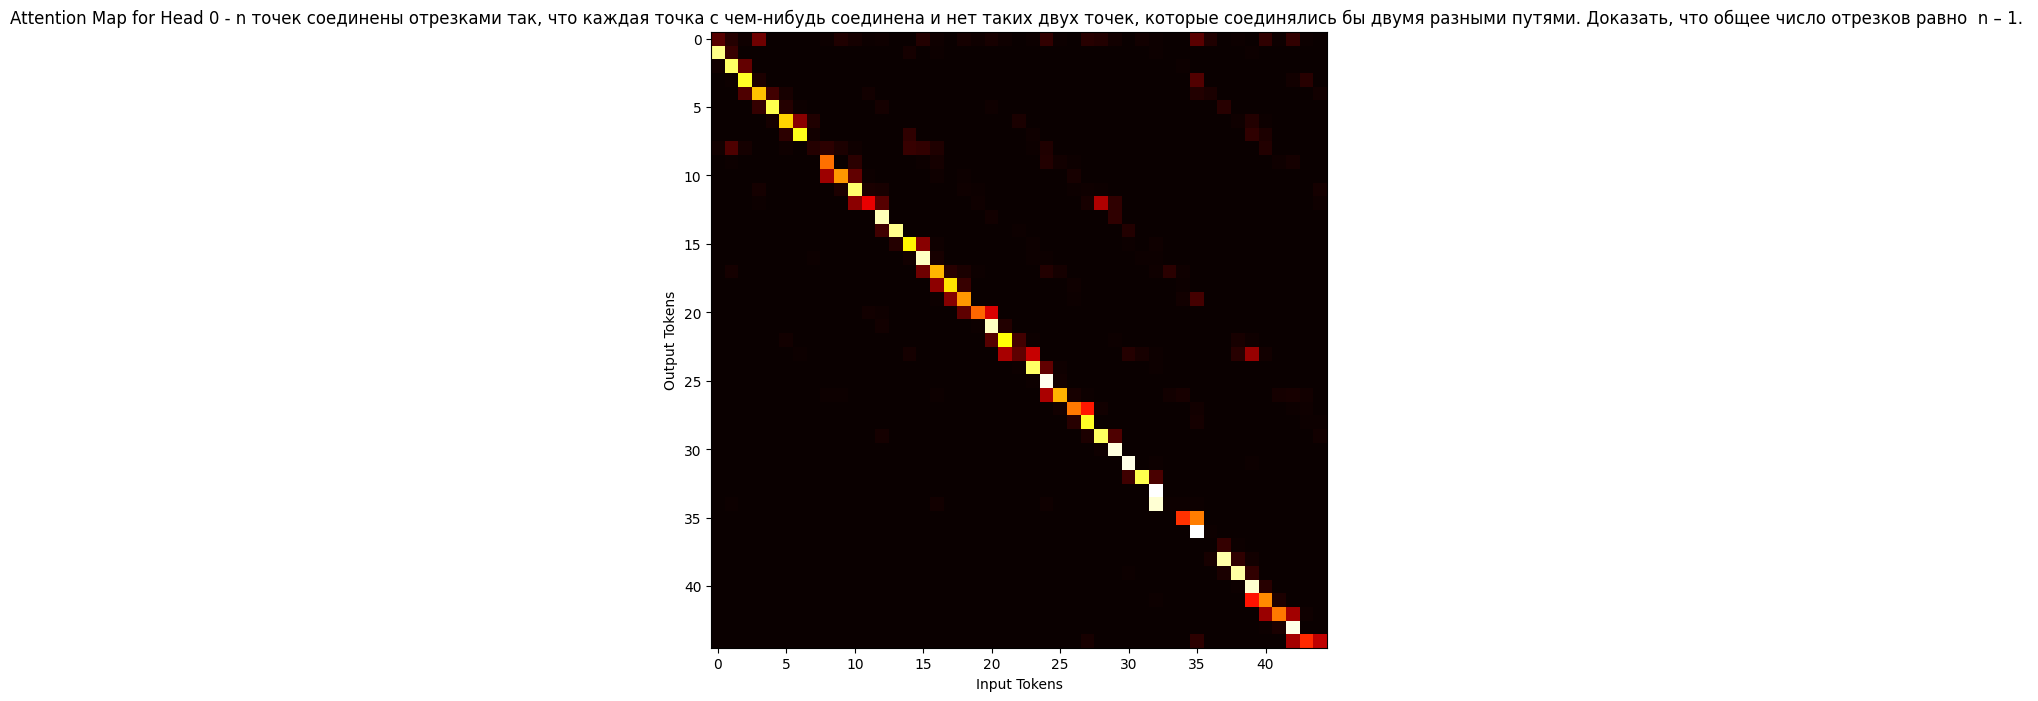

Model: rubert_tiny_full


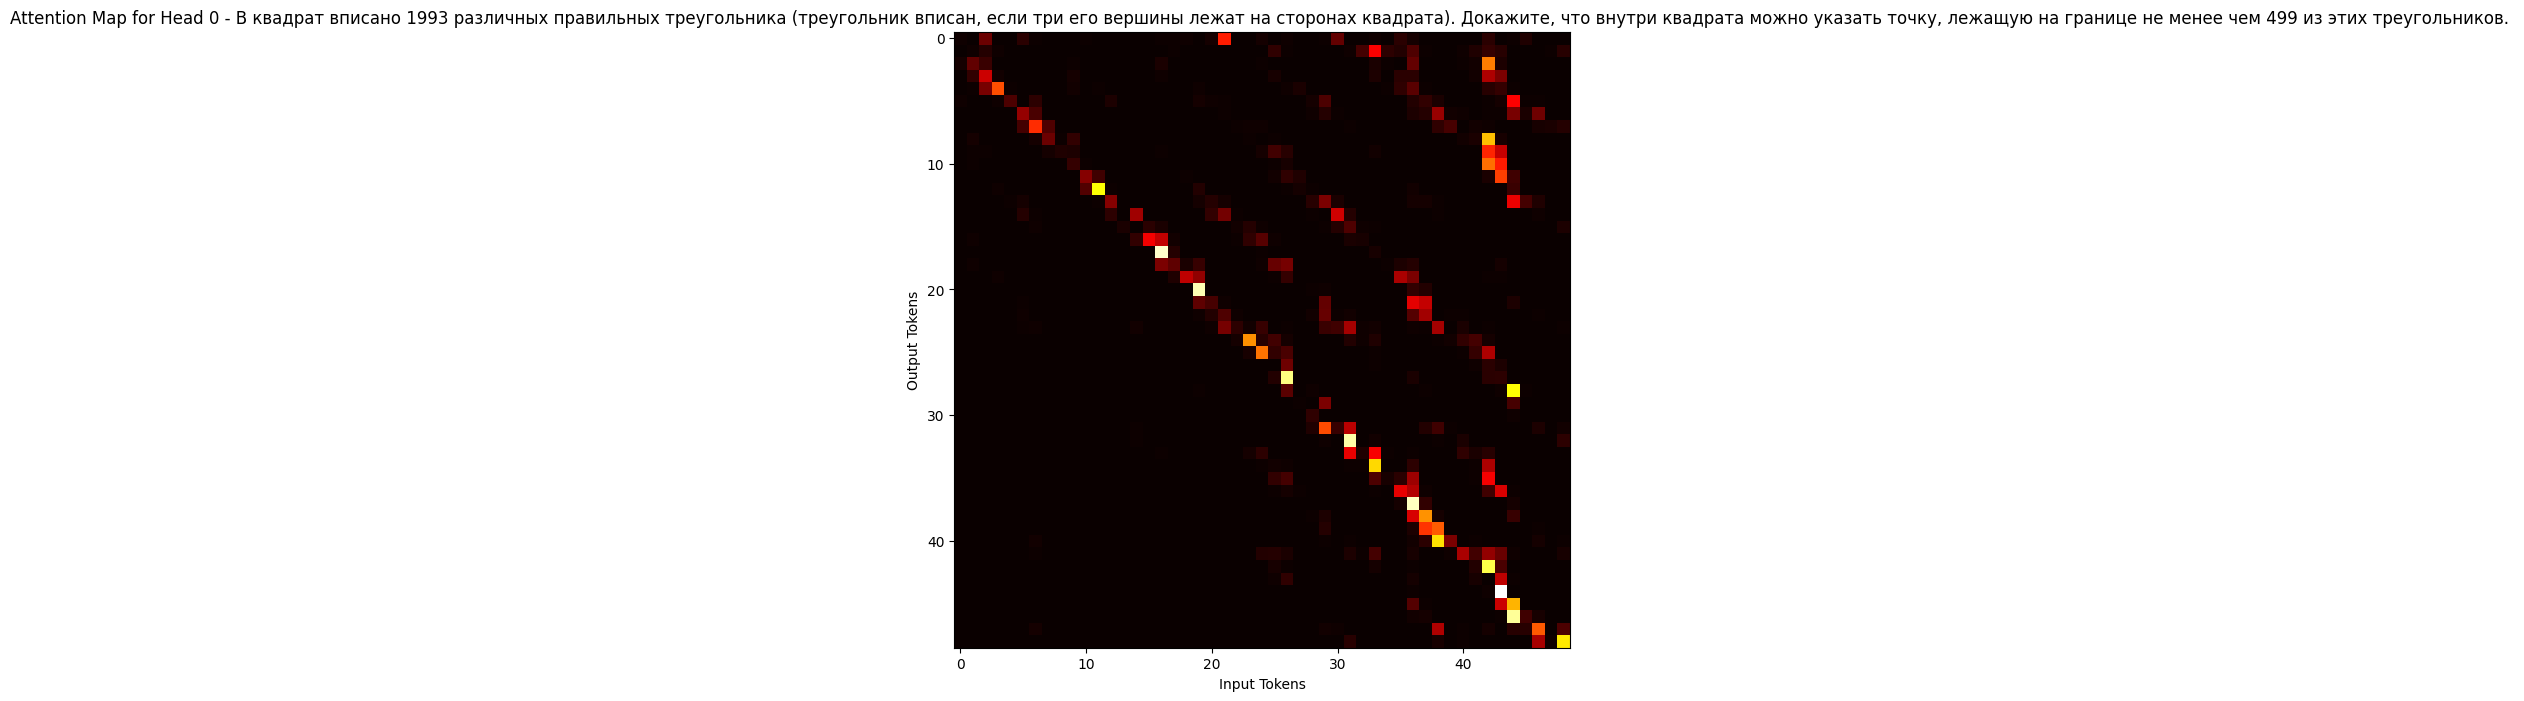

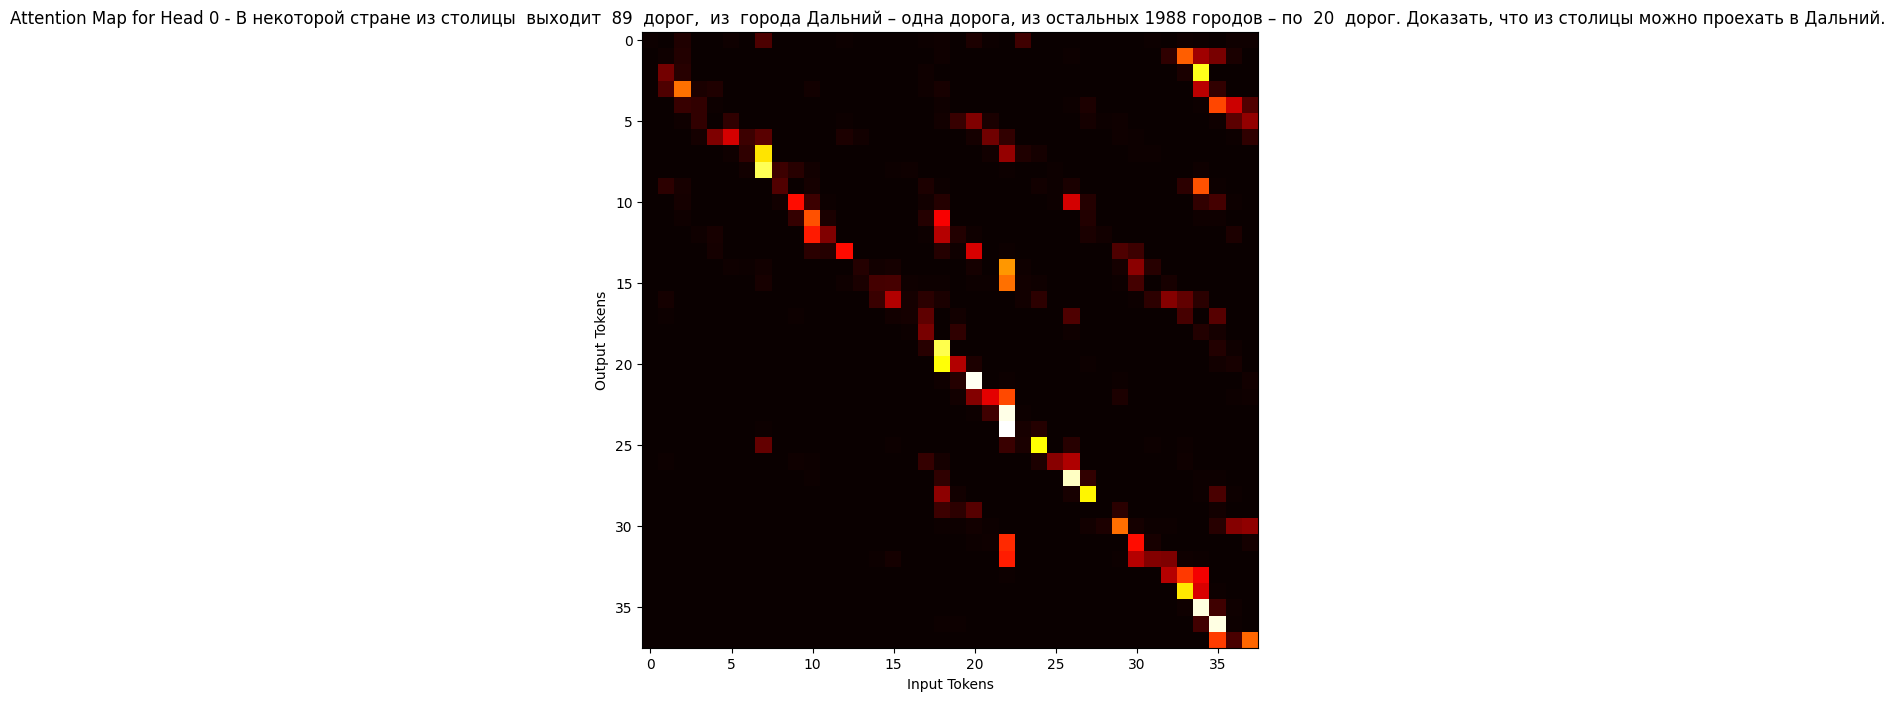

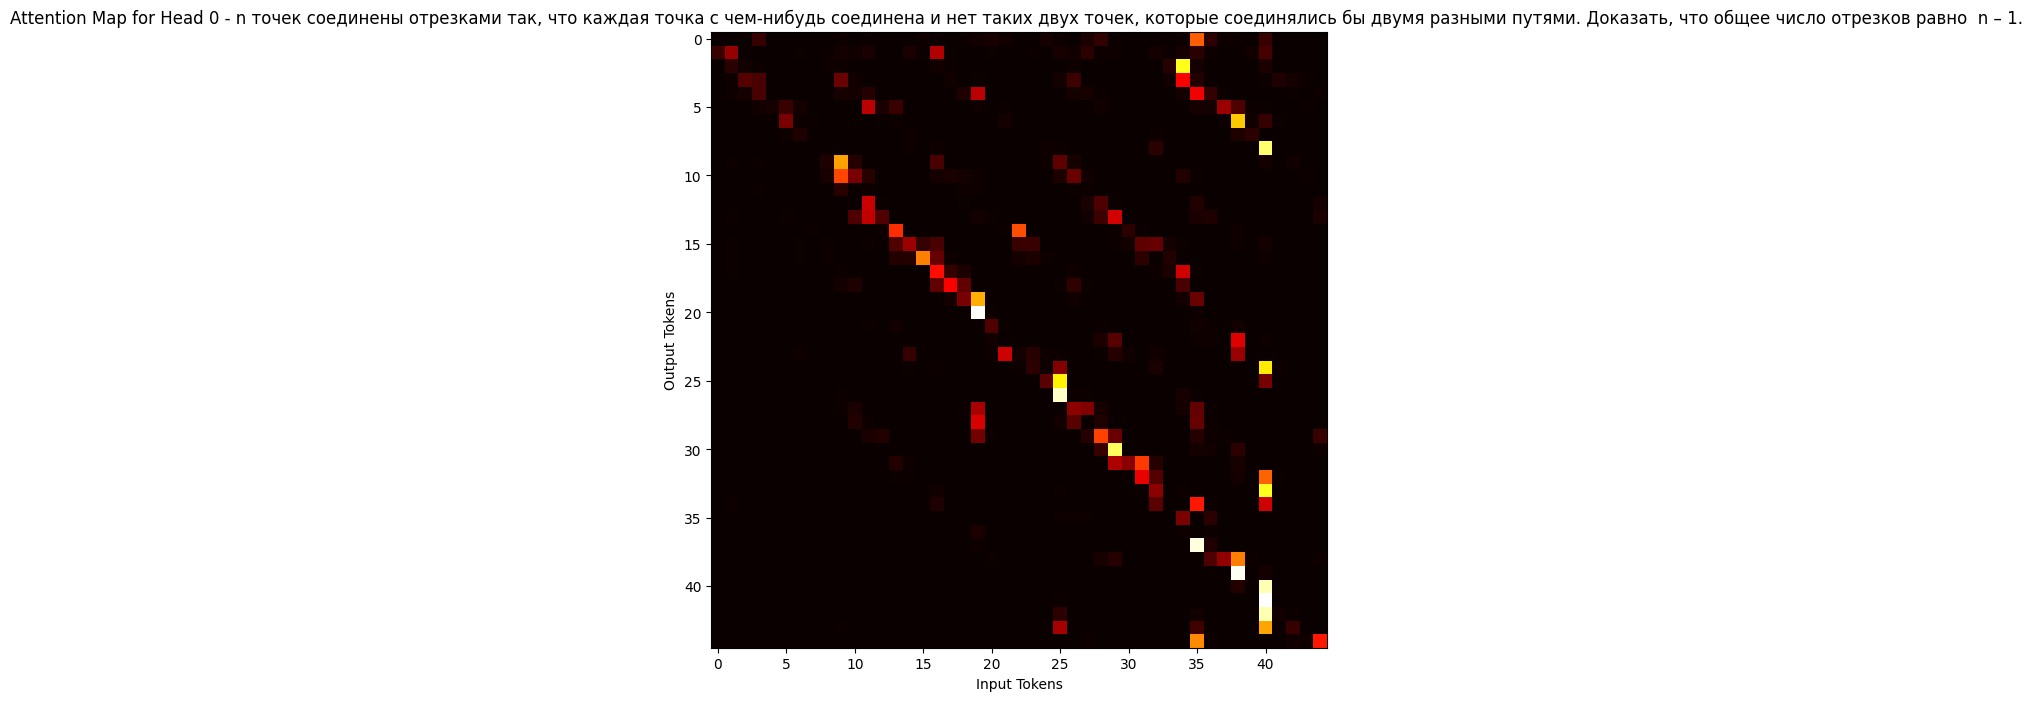

Model: mathbert_freezed


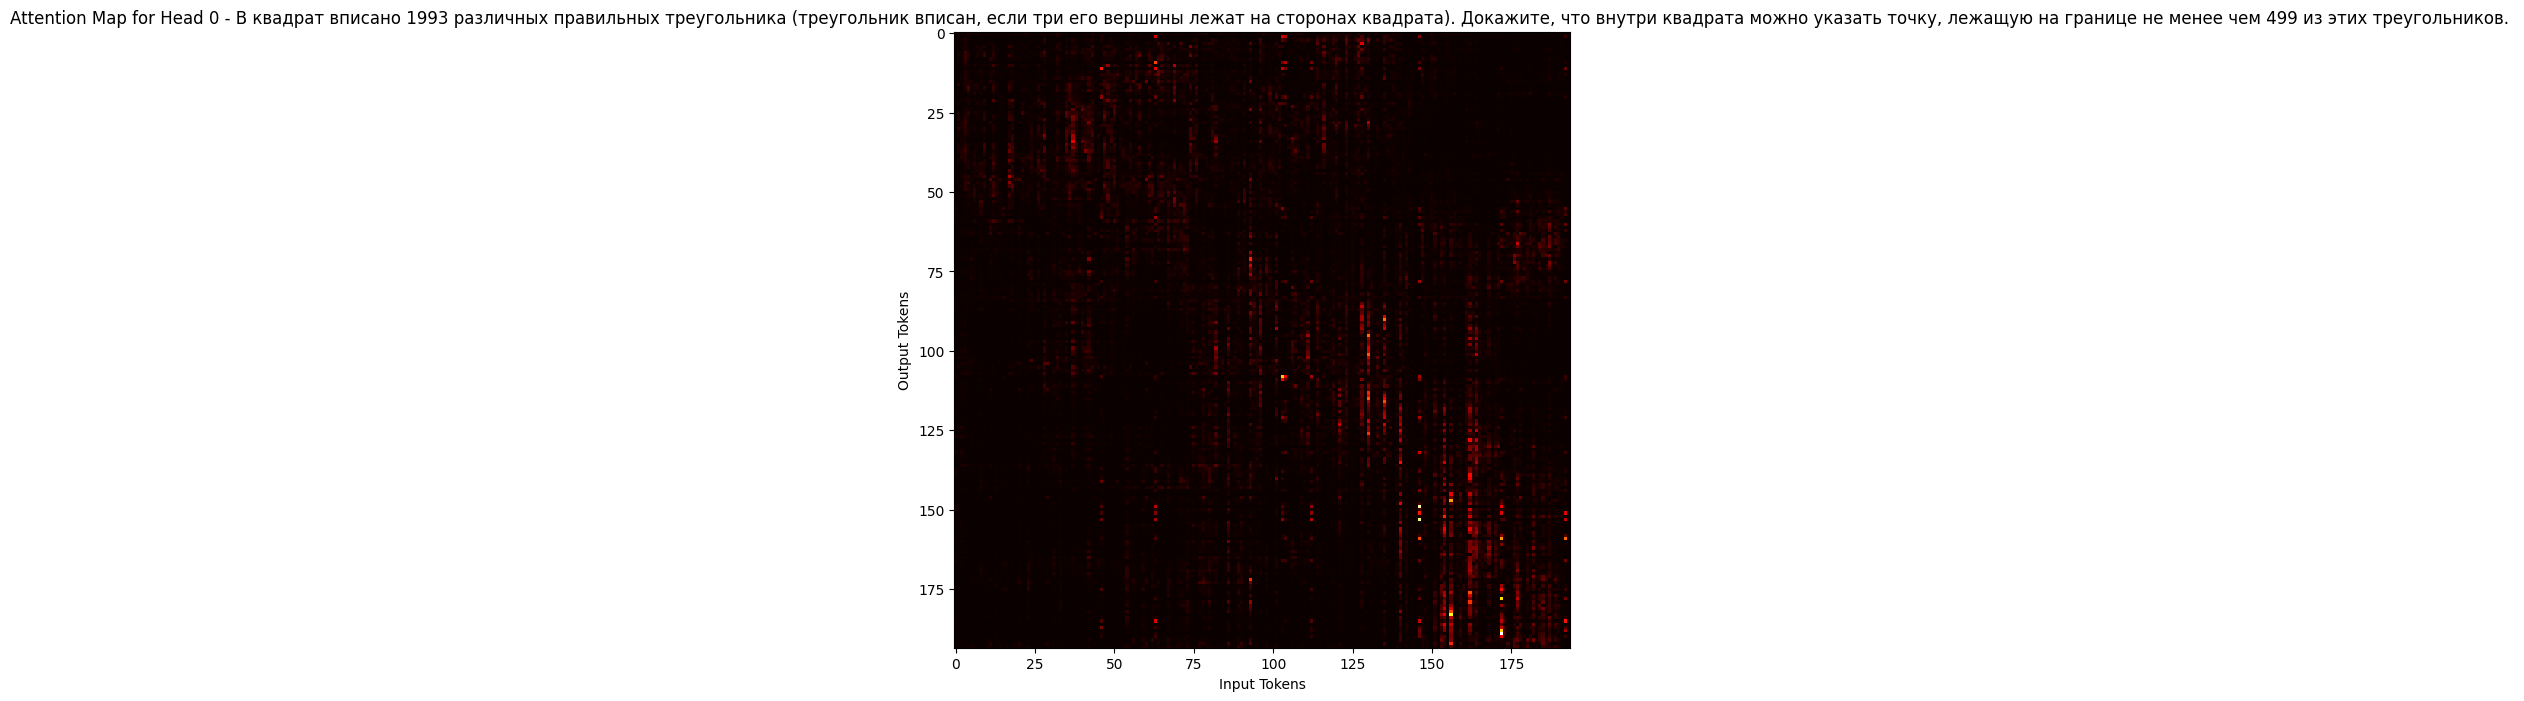

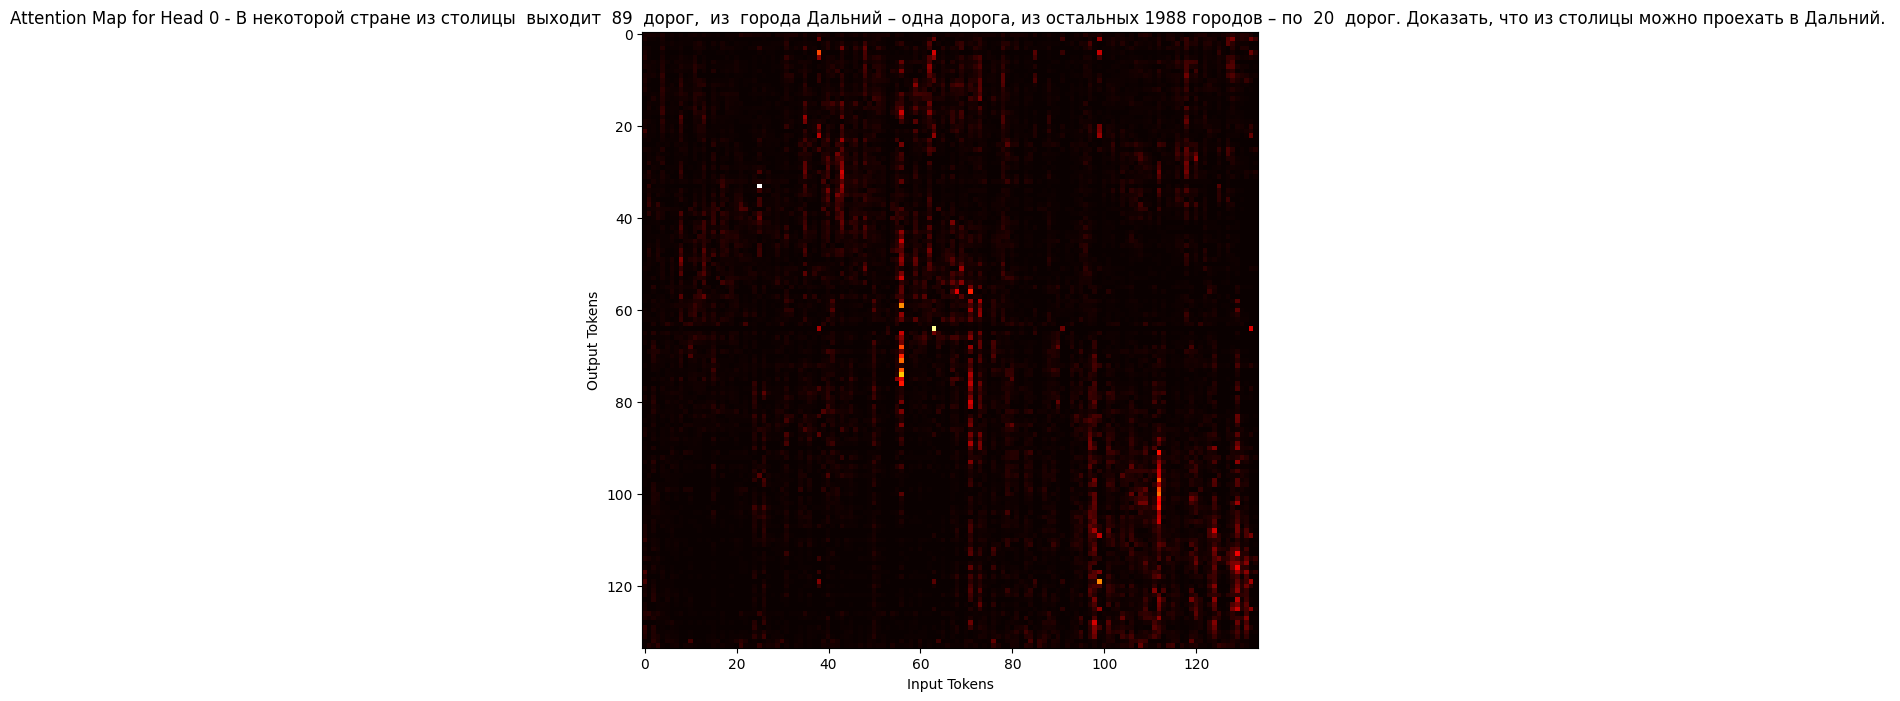

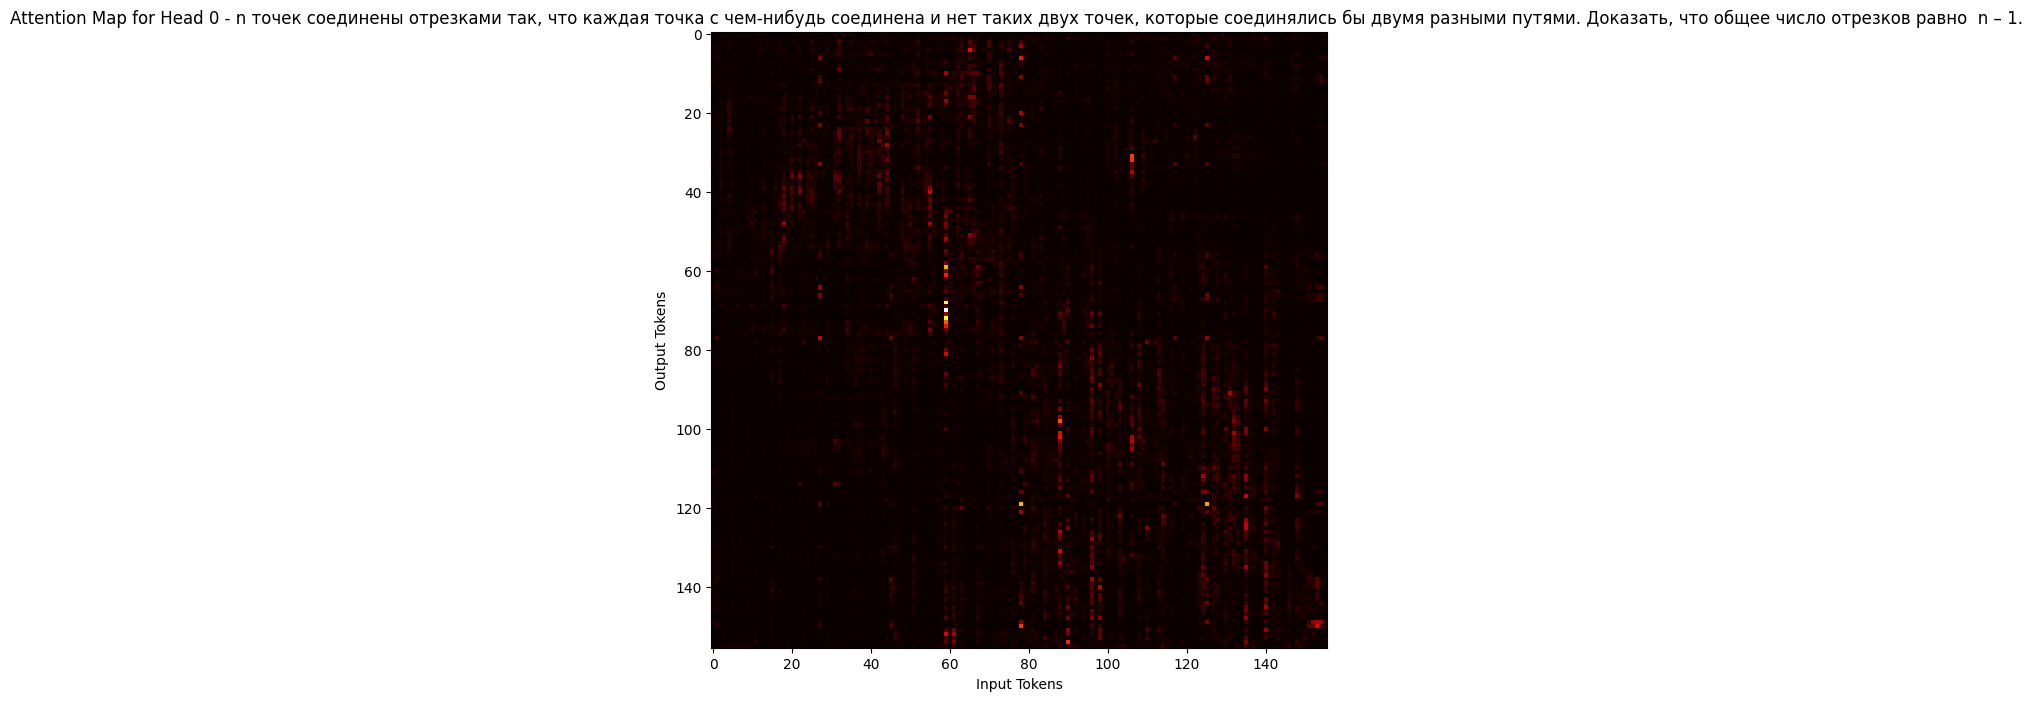

Model: mathbert_full


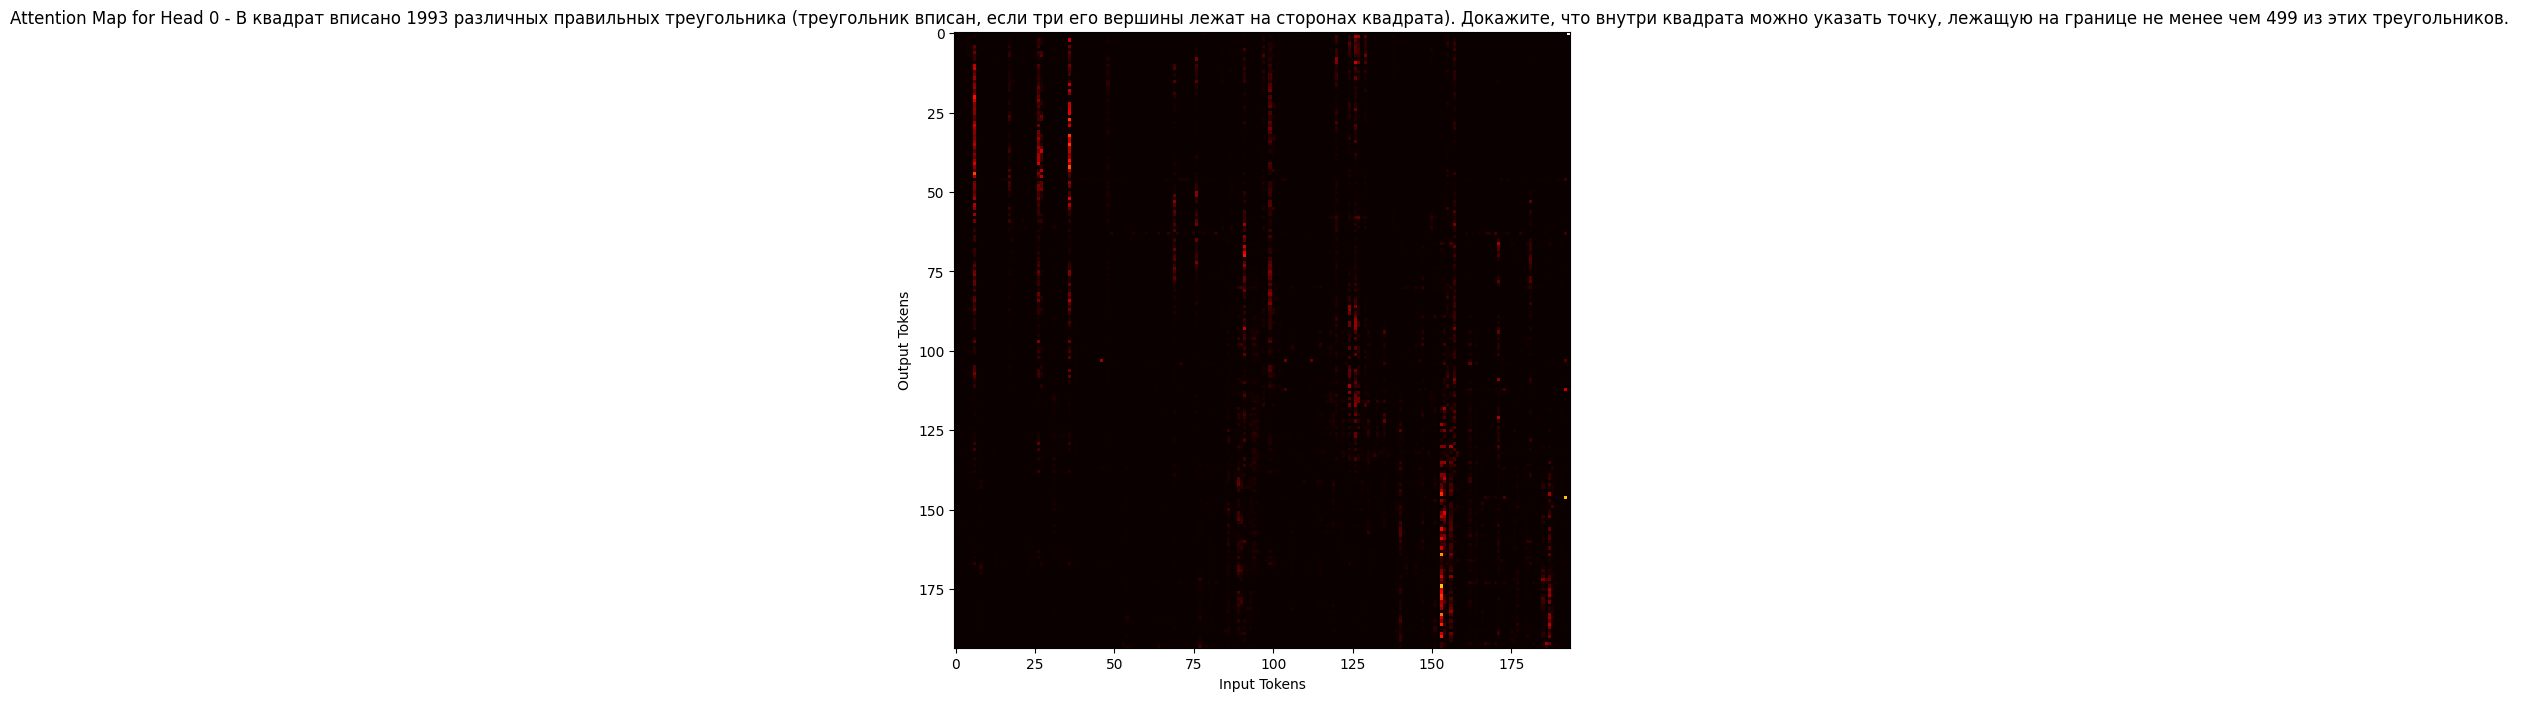

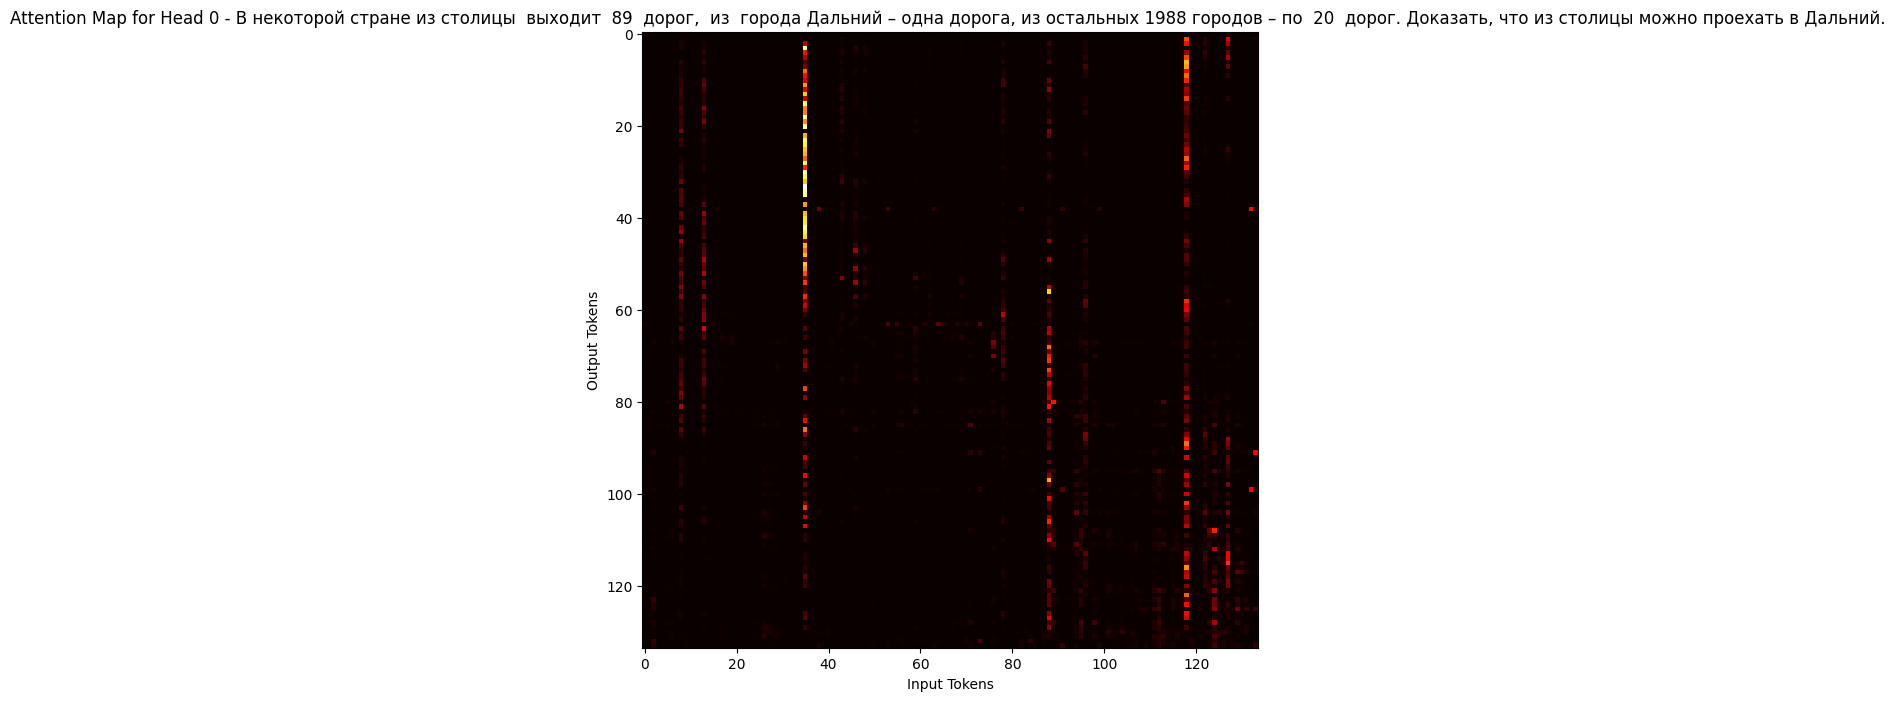

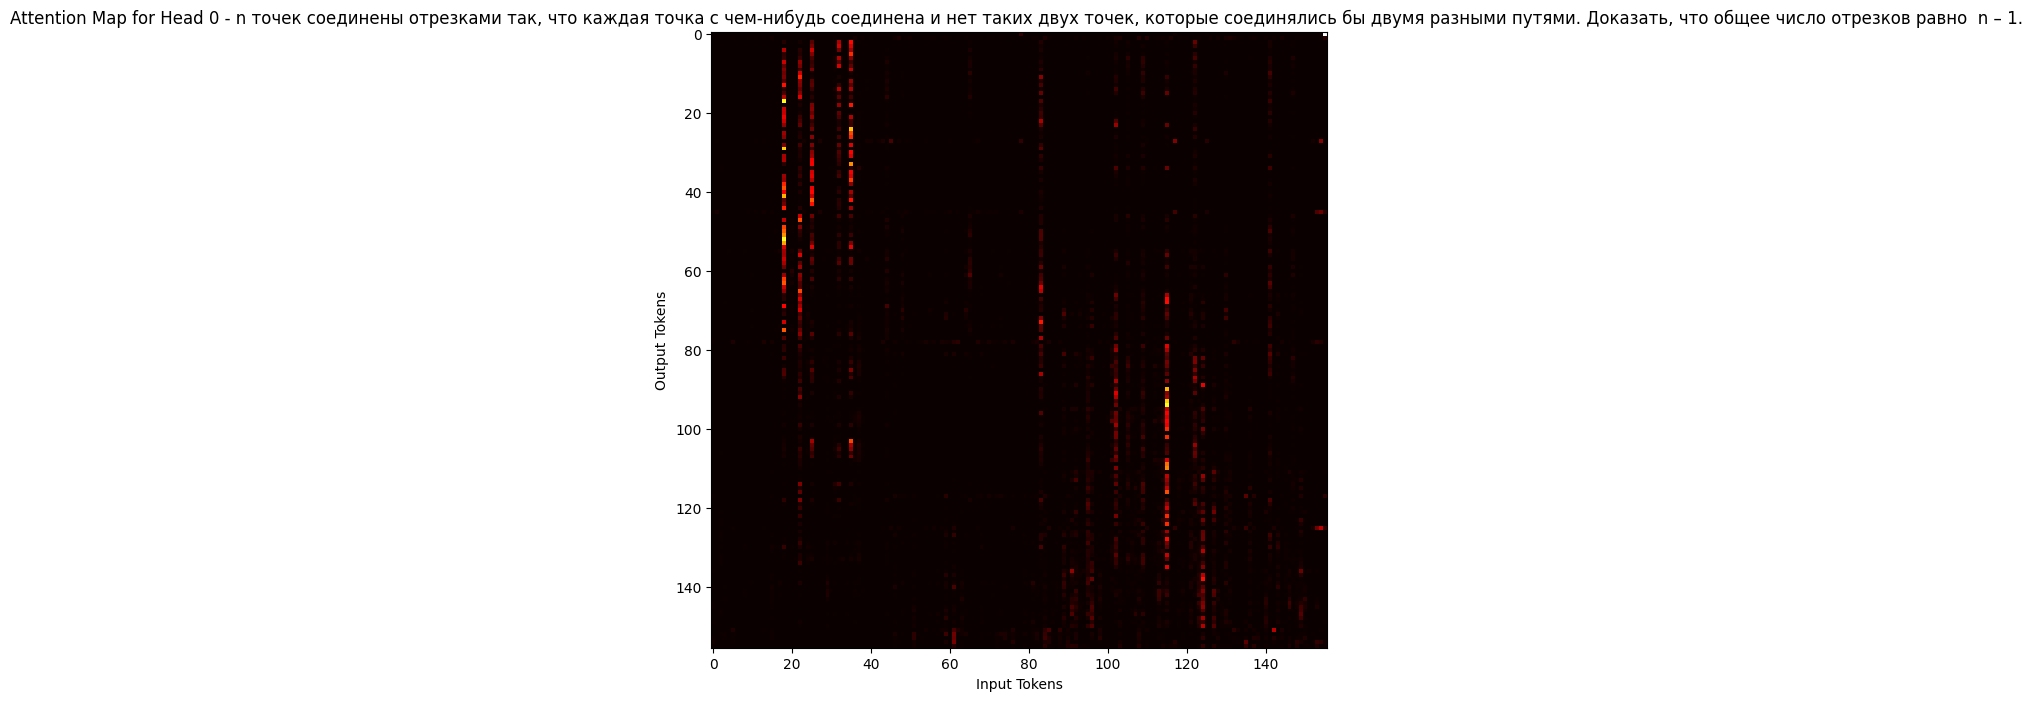

In [ ]:
### YOUR CODE IS HERE

### Пример использования для всех моделей после дообучения на выбранных текстах и анализе карт внимания

text_examples = ["В квадрат вписано 1993 различных правильных треугольника (треугольник вписан, если три его вершины лежат на сторонах квадрата). Докажите, что внутри квадрата можно указать точку, лежащую на границе не менее чем 499 из этих треугольников. ",
                "В некоторой стране из столицы  выходит  89  дорог,  из  города Дальний – одна дорога, из остальных 1988 городов – по  20  дорог. Доказать, что из столицы можно проехать в Дальний. ",
                "n точек соединены отрезками так, что каждая точка с чем-нибудь соединена и нет таких двух точек, которые соединялись бы двумя разными путями. Доказать, что общее число отрезков равно  n – 1. "]


# Пример инференса и анализа карт внимания после дообучения
for model_name, model in {
    'rubert_tiny_freezed': rubert_tiny_finetuned_with_freezed_backbone,
    'rubert_tiny_full': rubert_tiny_full_finetuned,
    'mathbert_freezed': mathbert_finetuned_with_freezed_backbone,
    'mathbert_full': mathbert_full_finetuned
}.items():
    print(f"Model: {model_name}")

    for text in text_examples:
        draw_first_layer_attention_maps(text, model)


Карты внимания изменились в соответствии с изменениями результатов моделей в плане Loss и Accuracy, примерно можно представить как соотношение имеющихся результатов 1 и 5 эпохи